In [1]:
#importing packages
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import random

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib.colors import ListedColormap

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.model_selection import cross_val_score
from sklearn.metrics import pairwise_distances

from sklearn.feature_selection import SelectKBest,f_classif,mutual_info_classif
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

In [2]:
#cell containing all the functions

def heatmap(df,string):
    '''
    This function generates a heat map of the provided dataframe with the tumor labels as y-axis and the gene expression as x-axis
    '''
    f,ax = plt.subplots()
    f.set_size_inches(20,20)

    ax=sns.heatmap(df,vmax=1,vmin=-1,cmap='coolwarm')
    #plt.xlim(50,80)
    #plt.ylim(58,62)
    plt.rcParams.update({'font.size':14})
    matplotlib.rc('xtick', labelsize=24)
    matplotlib.rc('ytick', labelsize=24)
    plt.title('Heatmap of Gene Expression Data'+' '+string,fontsize=24)

    plt.xlabel('Genes',fontsize=24)
    plt.ylabel('Tumor Label',fontsize=24)

    #plt.legend(loc='best',fontsize='large')
    plt.savefig('Heatmap of Gene Expression Data'+' '+string+'.png', dpi=300, bbox_inches='tight')
    plt.show()
    return


def fstat_classify(feature,target,test_feature,feature_names,k):
    fvalue_selector = SelectKBest(f_classif, k=k)
    X_factors=fvalue_selector.fit(feature,target.ravel()).transform(feature)
    X_fc_test=fvalue_selector.fit(feature,target.ravel()).transform(test_feature)
    mask = fvalue_selector.get_support()
    new_features = feature_names[mask]
    X_df=pd.DataFrame(X_factors,columns=new_features.tolist())
    y_df=pd.DataFrame(target,columns=['Class'])
    combined=pd.merge(X_df,y_df,left_index=True,right_index=True)
    combined.set_index('Class',inplace=True)
    combined.sort_index(inplace=True)
    #print (combined.head())
    string='F_classification Selected features '+str(k)
    heatmap(combined,string)
    return (new_features.tolist(),X_factors,X_fc_test)

def mutualinfo_classify(feature,target,test_feature,feature_names,k):
    fvalue_selector = SelectKBest(mutual_info_classif, k=k)
    X_factors=fvalue_selector.fit(feature,target.ravel()).transform(feature)
    X_mi_test=fvalue_selector.fit(feature,target.ravel()).transform(test_feature)
    mask = fvalue_selector.get_support()
    new_features = feature_names[mask]
    X_df=pd.DataFrame(X_factors,columns=new_features.tolist())
    y_df=pd.DataFrame(target,columns=['Class'])
    combined=pd.merge(X_df,y_df,left_index=True,right_index=True)
    combined.set_index('Class',inplace=True)
    combined.sort_index(inplace=True)
    #print (combined.head())
    string='Mutual Info Classification Selected features '+str(k)
    heatmap(combined,string)
    return (new_features.tolist(),X_factors,X_mi_test)


def tuning(model,X_fclass,X_minfo,y_tr,Xtr_pca,Xtr_lda):
    fclass_cv_score=cross_val_score(model,X_fclass,y_tr,cv=5,scoring='accuracy').mean()
    mutualinfo_cv_score=cross_val_score(model,X_minfo,y_tr,cv=5,scoring='accuracy').mean()
    pca_cv_score=cross_val_score(model,Xtr_pca,y_tr,cv=5,scoring='accuracy').mean()
    lda_cv_score=cross_val_score(model,Xtr_lda,y_tr,cv=5,scoring='accuracy').mean()
    return (fclass_cv_score,mutualinfo_cv_score,pca_cv_score,lda_cv_score)


def plot_cv(parameters,fclass_scoring,minfo_scoring,pca_scoring,lda_scoring,title,xlabel):
    f,ax = plt.subplots()
    f.set_size_inches(10,10)

    plt.plot(parameters,fclass_scoring,'k',label='F_classify')
    plt.plot(parameters,minfo_scoring,'r',label='Mutual Info Classify')
    plt.plot(parameters,pca_scoring,'b',label='PCA')
    plt.plot(parameters,lda_scoring,'g',label='LDA')
    
    #plt.xlim(50,80)
    #plt.ylim(58,62)
    plt.rcParams.update({'font.size':12})
    matplotlib.rc('xtick', labelsize=20)
    matplotlib.rc('ytick', labelsize=20)
    plt.title(title,fontsize='larger')

    plt.xlabel(xlabel,fontsize='larger')
    plt.ylabel('Accuracy',fontsize='larger')

    plt.legend(loc='best',fontsize='large')
    plt.savefig(title+'.png', dpi=300, bbox_inches='tight')
    plt.show()
    return

def calc_class_metrics(model,X_train,y_train,X_test,y_test,name):
    pred_class=model.fit(X_train,y_train).predict(X_test)
    accuracy=model.score(X_test,y_test)
    print ('Model:{},Accuracy:{}'.format(name,accuracy))
    print ('Model:',name)
    print (classification_report(y_test,pred_class,labels=[0,1,2,3,4]))
    return pred_class

def plot_cfmat(true_label,cl_lab,name):
    matrix = confusion_matrix(true_label, cl_lab)


    plt.figure(figsize=(6,6))
    plt.suptitle("Confusion Matrices: "+name,fontsize=24)

    plt.title("Tumor Types")

    sns.heatmap(matrix, annot = True,xticklabels=[0,1,2,3,4],yticklabels=[0,1,2,3,4],fmt='0g',cmap="Blues",cbar=False)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.show()
    return

def check_multicol(array,name_list,text):
    vif_df=pd.DataFrame()
    vif_df['Features']=name_list
    vif_df["VIF"] = [variance_inflation_factor(pd.DataFrame(array).values, i)
                          for i in range(len(name_list))]
    print (text)
    print (vif_df)
    return vif_df

def log_coeff(array,target,name,string):
    logreg=LogisticRegression(penalty='elasticnet',C=1,solver='saga',l1_ratio=0.5,multi_class='multinomial',max_iter=100000)
    logreg.fit(array,target)

    #print ('Elastic Net Logistic Regression Coefficients:',logreg.coef_)
    print ('Elastic Net Logistic Regression Intercept:',logreg.intercept_)

    coefficients={'0':{},'1':{},'2':{},'3':{},'4':{}}
    coefficients['Features']=name
    for j in range(len(logreg.intercept_)):
            coefficients[str(j)]=logreg.coef_[j,:]

    print ('Elastic Net Logistic Regressionn Coefficients:'+string+':')
    print (pd.DataFrame(coefficients))
    coef_df=pd.DataFrame(coefficients)
    return coef_df

def plot_boundary(model,name,xx,yy):
     
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    
    f,ax = plt.subplots()
    f.set_size_inches(10,5)
    cm = plt.cm.Paired
    cm_bright = ListedColormap(['blue','green','red','violet','brown'])
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.5)
    ax.scatter(X_ldas_train[:,0],X_ldas_train[:,1],marker='o',c=y_train,cmap=cm_bright)
    ax.scatter(X_ldas_test[:,0],X_ldas_test[:,1],marker='*',c=y_test,cmap=cm_bright)
    #plt.xlim(50,80)
    #plt.ylim(58,62)
    plt.rcParams.update({'font.size':12})
    matplotlib.rc('xtick', labelsize=20)
    matplotlib.rc('ytick', labelsize=20)
    plt.title(name+' LDA representation decision boundary',fontsize='larger')

    plt.xlabel('LDA 1',fontsize='larger')
    plt.ylabel('LDA 2',fontsize='larger')

    #plt.legend(loc='best',fontsize='large')
    plt.savefig(name+' LDA representation decision boundary.png', dpi=300, bbox_inches='tight')
    plt.show()
    return


In [3]:
#importing data
X=pd.read_csv('data.csv')

#print (X.head())
#print (X.shape)
y=pd.read_csv('labels.csv')

#combined=pd.merge(X,y,on='Unnamed: 0')
X=X.drop('Unnamed: 0',axis=1)
y=y.drop('Unnamed: 0',axis=1)
print (y.head())
#print (y.shape)

feature_names=X.columns



  Class
0  PRAD
1  LUAD
2  PRAD
3  PRAD
4  BRCA


In [4]:
#describing and cleaning up the data the data

print ('No.of unique y-labels:\n',y.value_counts())
y=OrdinalEncoder().fit(y).transform(y)
print ('No.of unique y-labels:\n',np.unique(y, return_counts=True))
print ('Checking for NaN:',X.isnull().any(axis=1).sum())

#Using Standard Scaler on the dat and splitting into train and test set
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=44)




No.of unique y-labels:
 Class
BRCA     300
KIRC     146
LUAD     141
PRAD     136
COAD      78
dtype: int64
No.of unique y-labels:
 (array([0., 1., 2., 3., 4.]), array([300,  78, 146, 141, 136], dtype=int64))
Checking for NaN: 0


         gene_0    gene_1    gene_2    gene_3    gene_4  gene_5    gene_6  \
Class                                                                       
0.0   -0.194799  1.031262 -0.639981  0.992162  1.409508     0.0 -0.617532   
0.0   -0.194799  0.398407  0.390472 -0.602399  0.759528     0.0  1.865558   
0.0   -0.194799 -0.529371 -0.334068 -0.358767  0.820588     0.0 -1.335662   
0.0   -0.194799  1.099284  0.446496  0.500431 -0.617550     0.0 -0.972864   
0.0   -0.194799 -0.480125 -0.294214 -0.354349 -1.056011     0.0 -0.182655   

         gene_7    gene_8    gene_9  ...  gene_20521  gene_20522  gene_20523  \
Class                                ...                                       
0.0   -0.983088 -0.125376 -0.065633  ...   -0.982508    0.043329   -2.104052   
0.0   -0.983088 -0.125376 -0.065633  ...   -1.959459   -1.330738   -0.089066   
0.0    0.347065  2.700507 -0.065633  ...   -1.466166   -0.463560   -0.607275   
0.0    0.279876 -0.125376 -0.065633  ...    0.777059    0.45

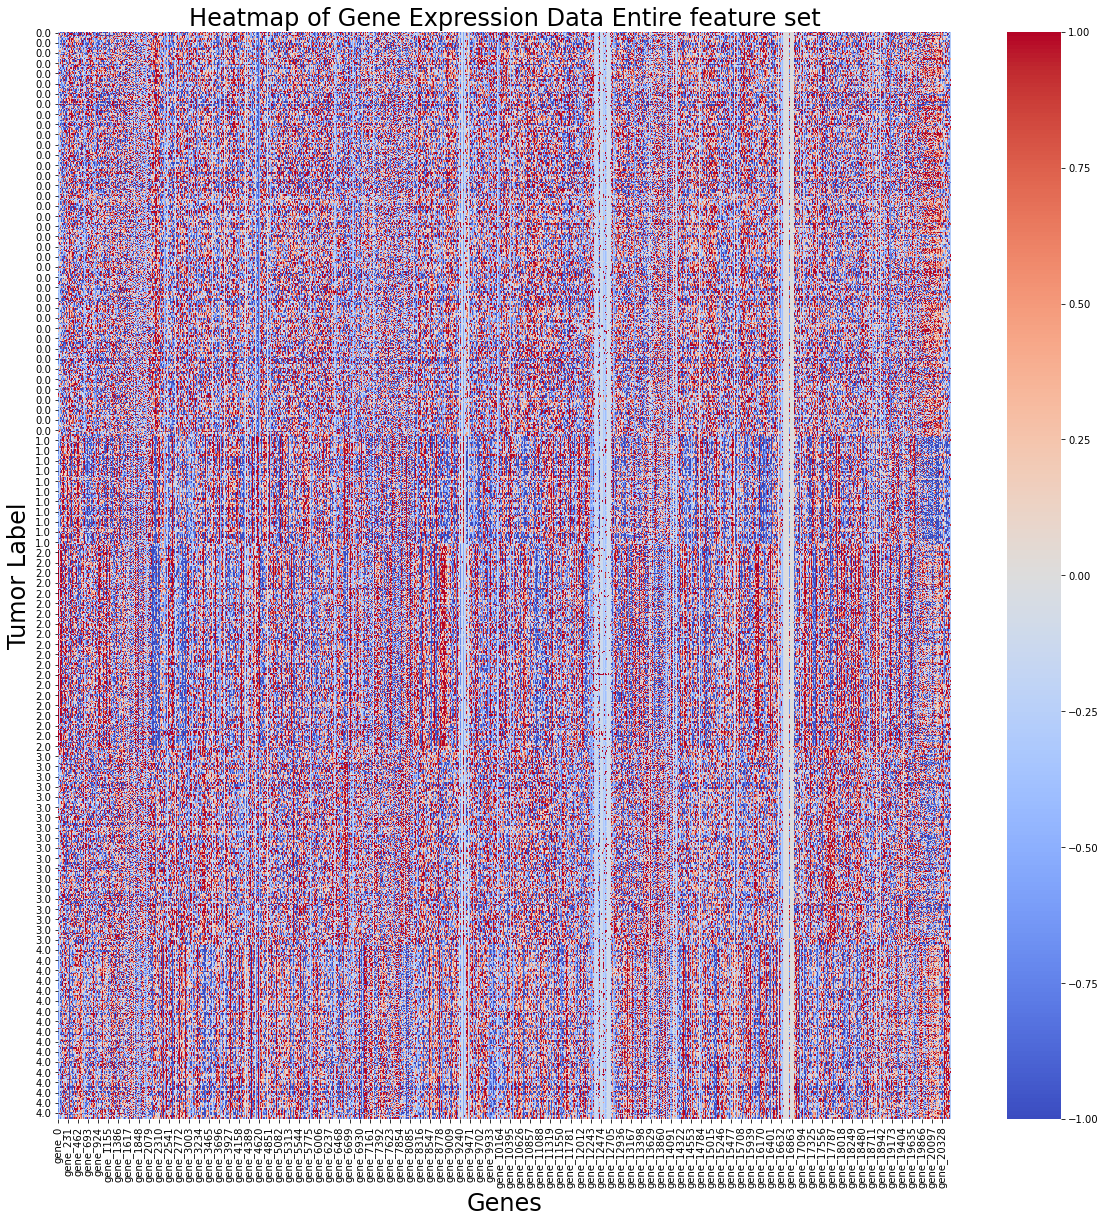

This is high dimensional dataset. Therefore, dimensional reduction will be done before EDA


In [5]:
#exploratory data analysis
Xtrain_df=pd.DataFrame(X_train,columns=feature_names.tolist())
ytrain_df=pd.DataFrame(y_train,columns=['Class'])
combined=pd.merge(Xtrain_df,ytrain_df,left_index=True,right_index=True)
combined.set_index('Class',inplace=True)
combined.sort_index(inplace=True)
print (combined.head())

heatmap(combined,'Entire feature set')
print ('This is high dimensional dataset. Therefore, dimensional reduction will be done before EDA')


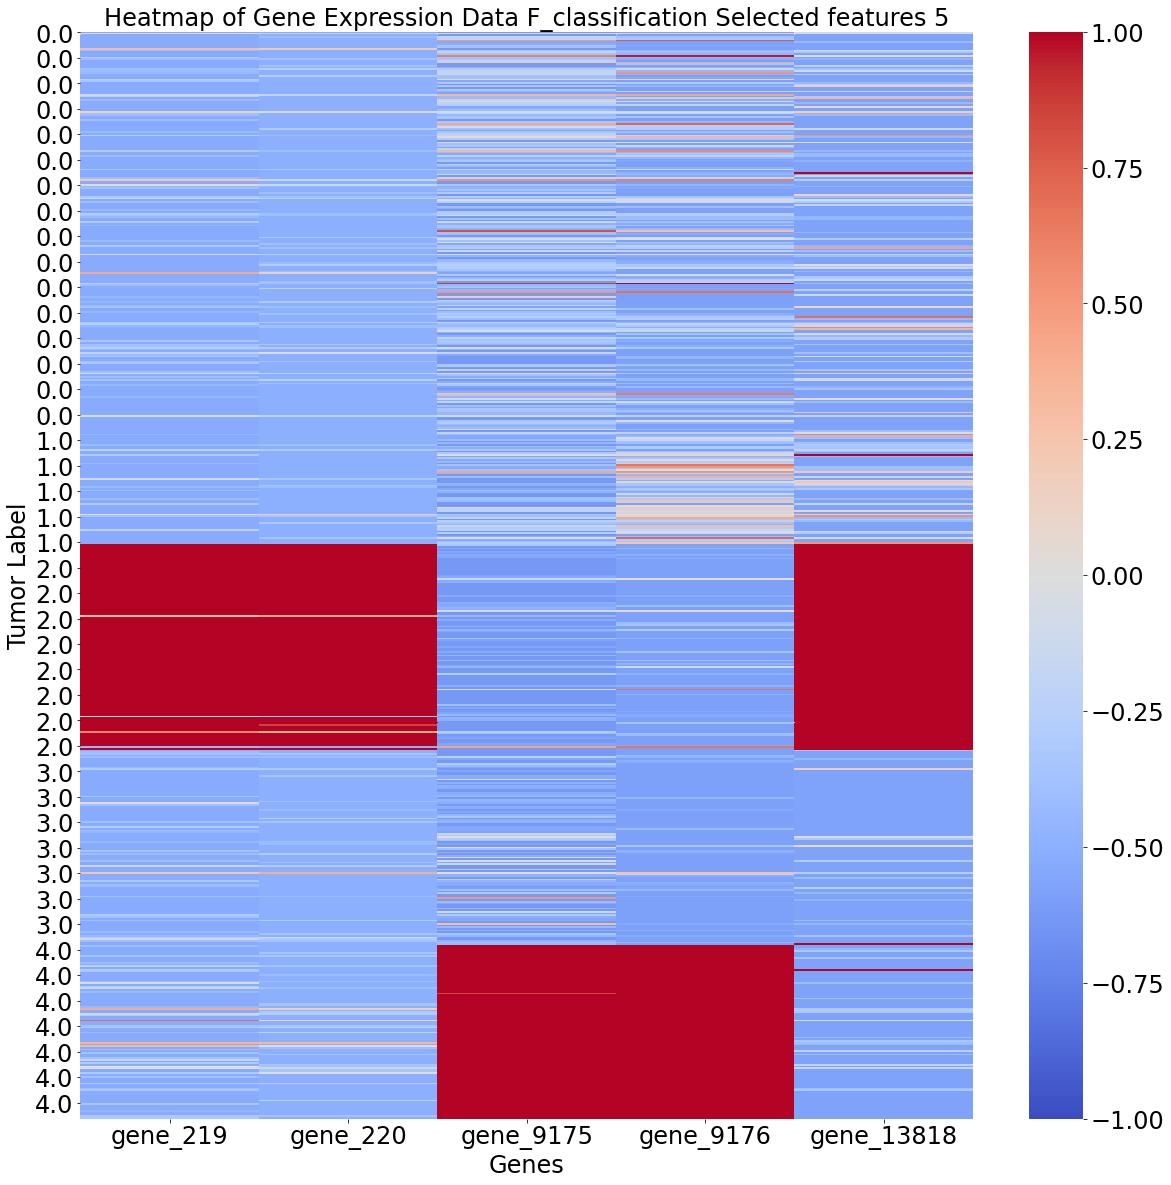

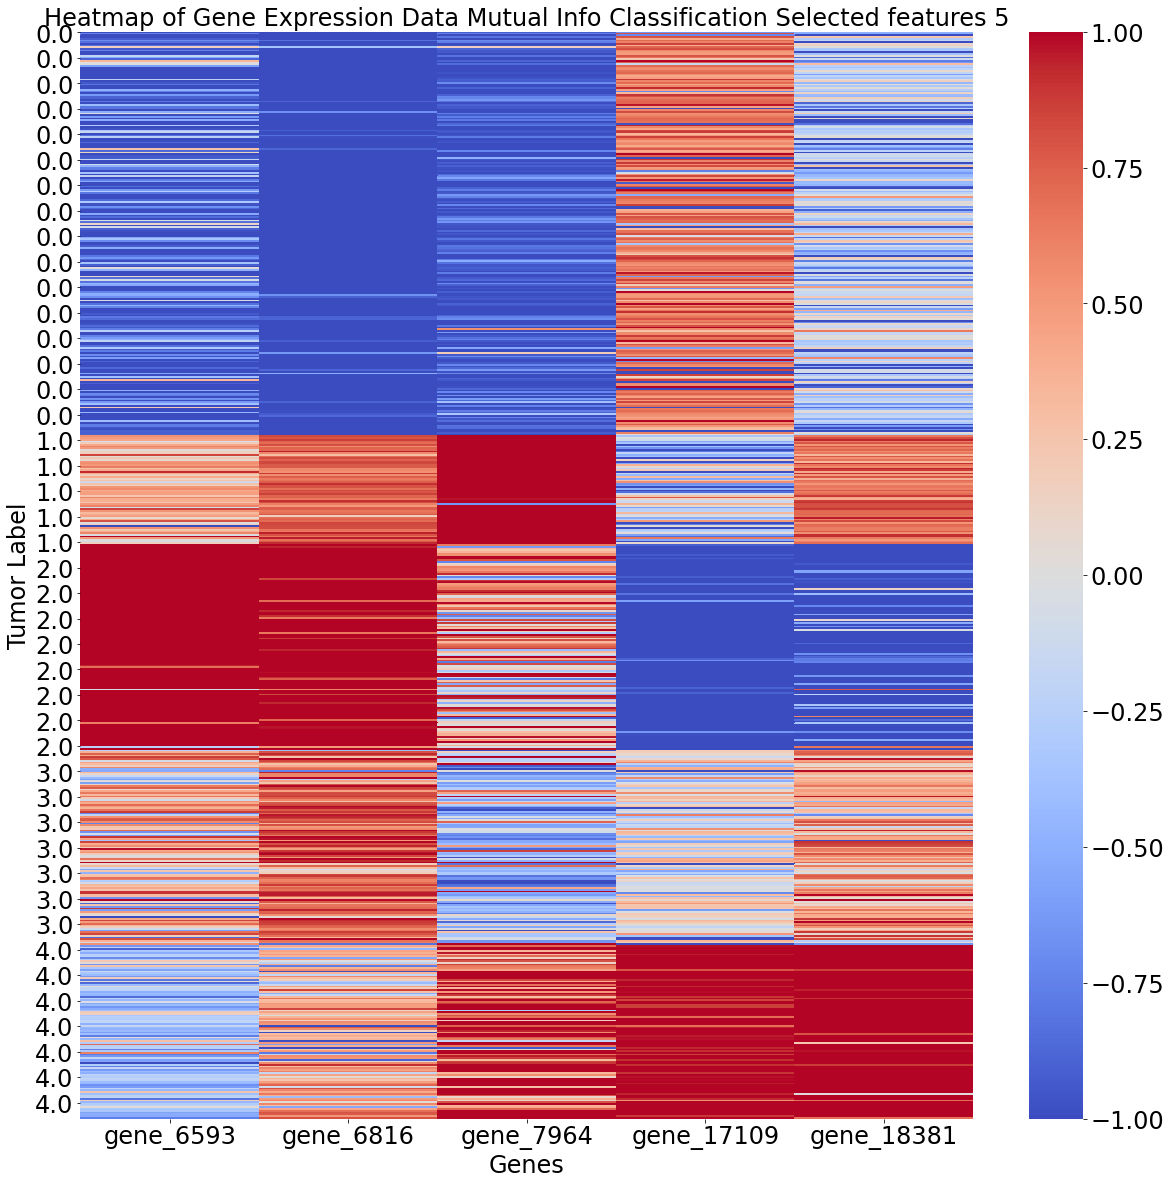

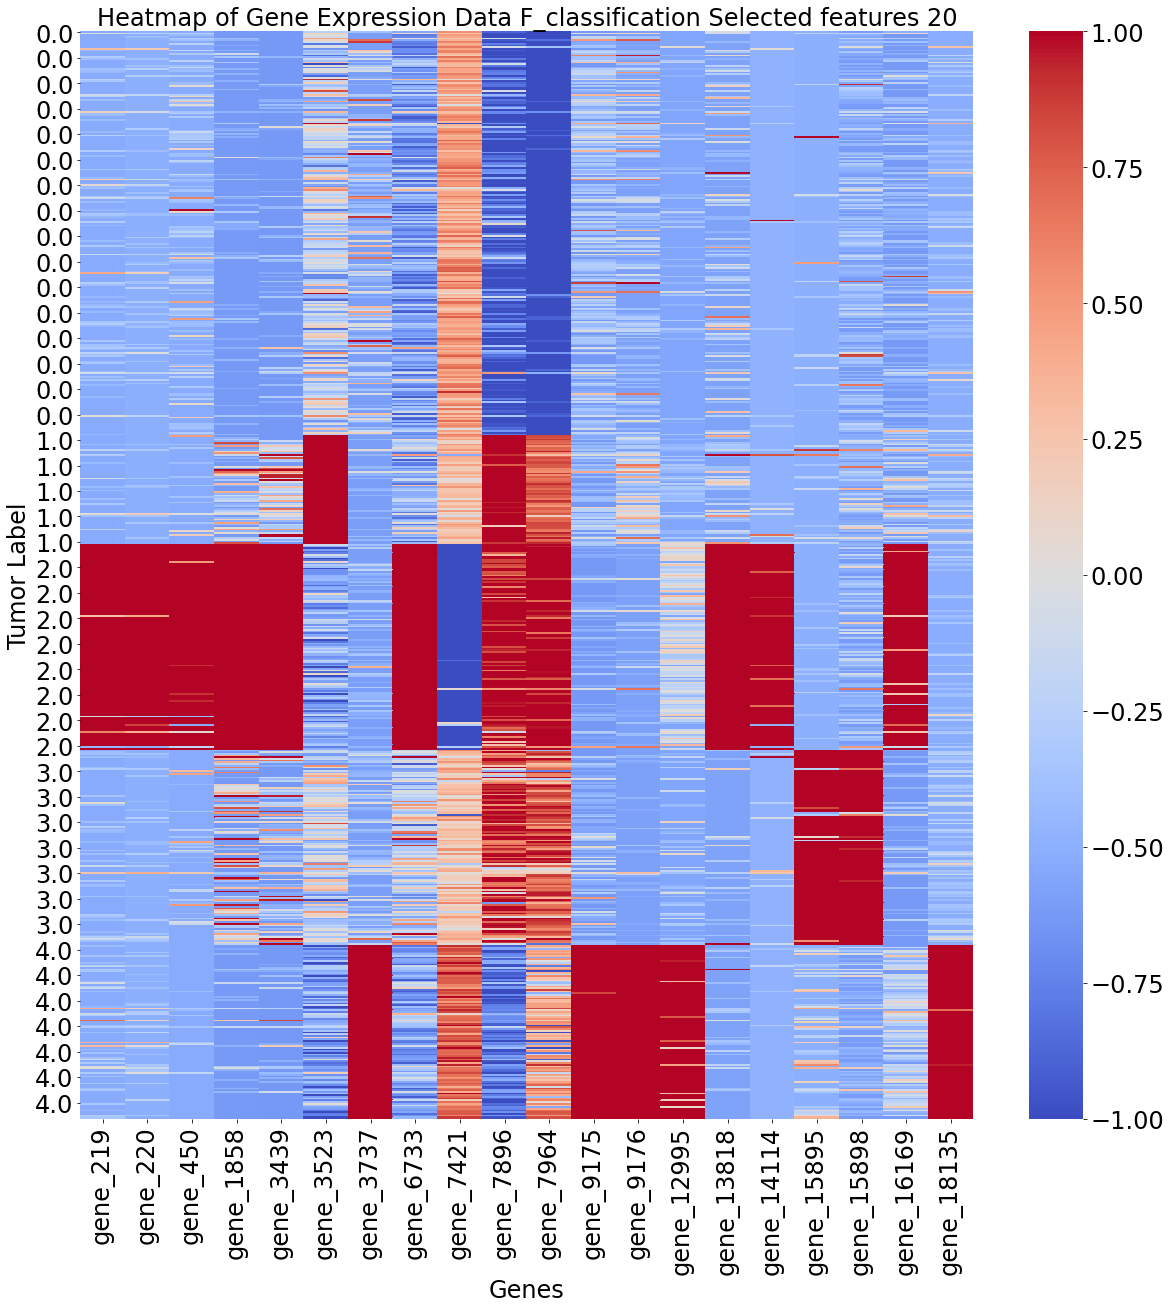

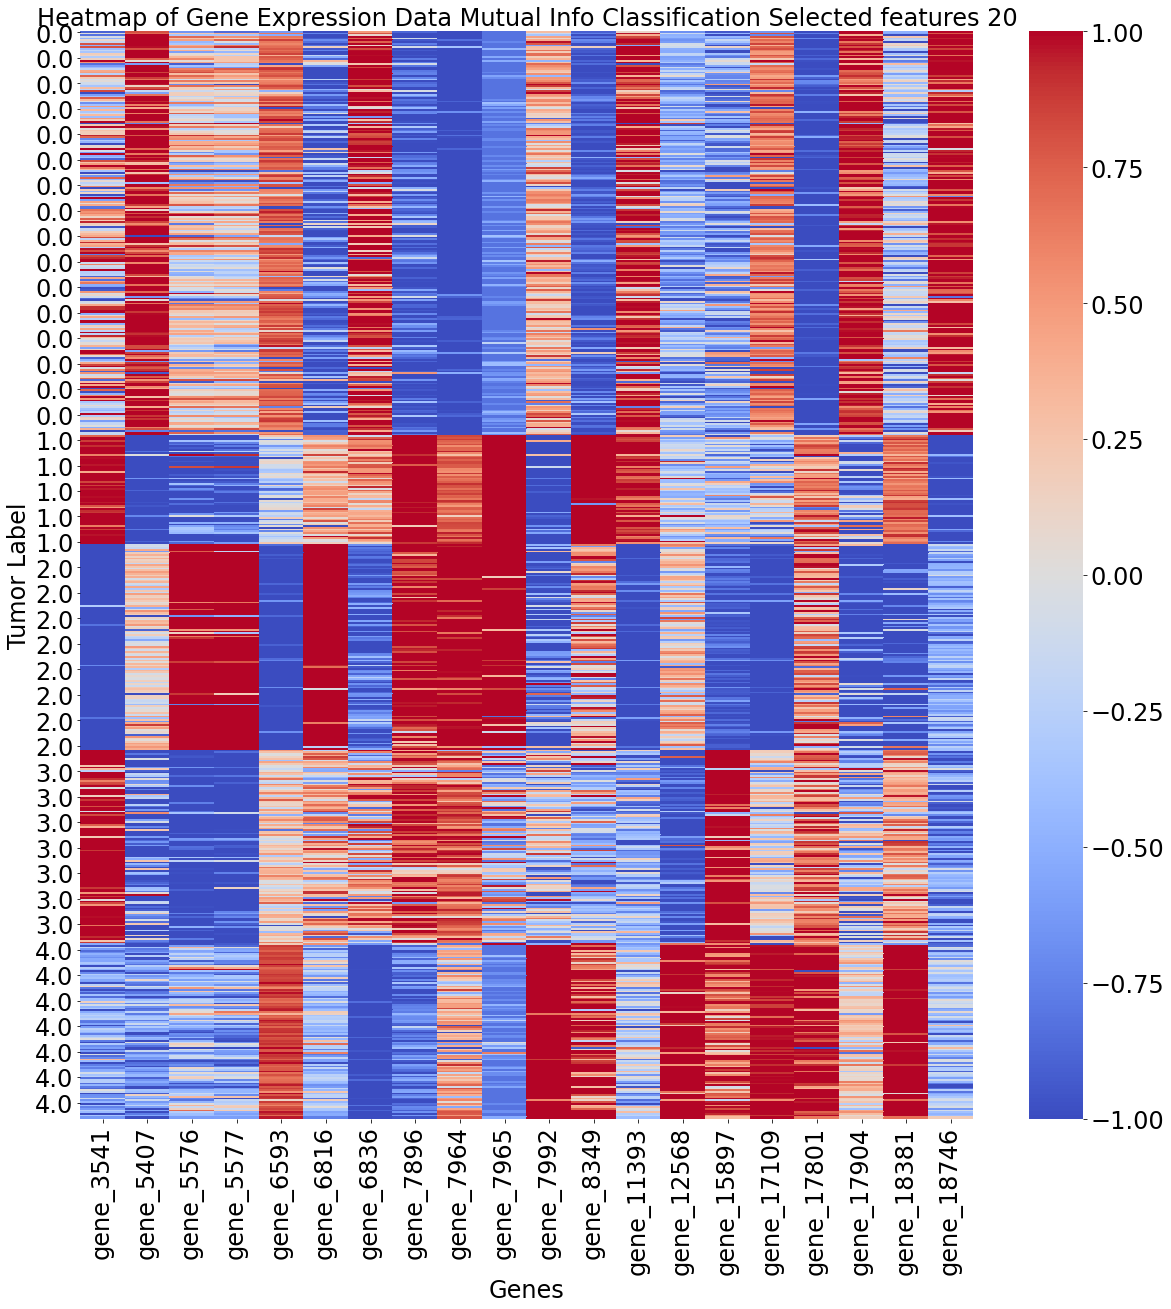

In [6]:
#factor selection using f_classif and mutual info classif

#K=[5,10,20,40,50,80,100]
K=[5,20]
fclass_list=[]
mutualinfo_list=[]
fclass_test_list=[]
mutualinfo_test_list=[]
fclass_name=[]
mutualinfo_name=[]
for k in K:
    fc_tuple=fstat_classify(X_train,y_train,X_test,feature_names,k)
    mi_tuple=mutualinfo_classify(X_train,y_train,X_test,feature_names,k)
    fclass_name.append(fc_tuple[0])
    fclass_list.append(fc_tuple[1])
    mutualinfo_name.append(mi_tuple[0])
    mutualinfo_list.append(mi_tuple[1])
    fclass_test_list.append(fc_tuple[2])
    mutualinfo_test_list.append(mi_tuple[2])





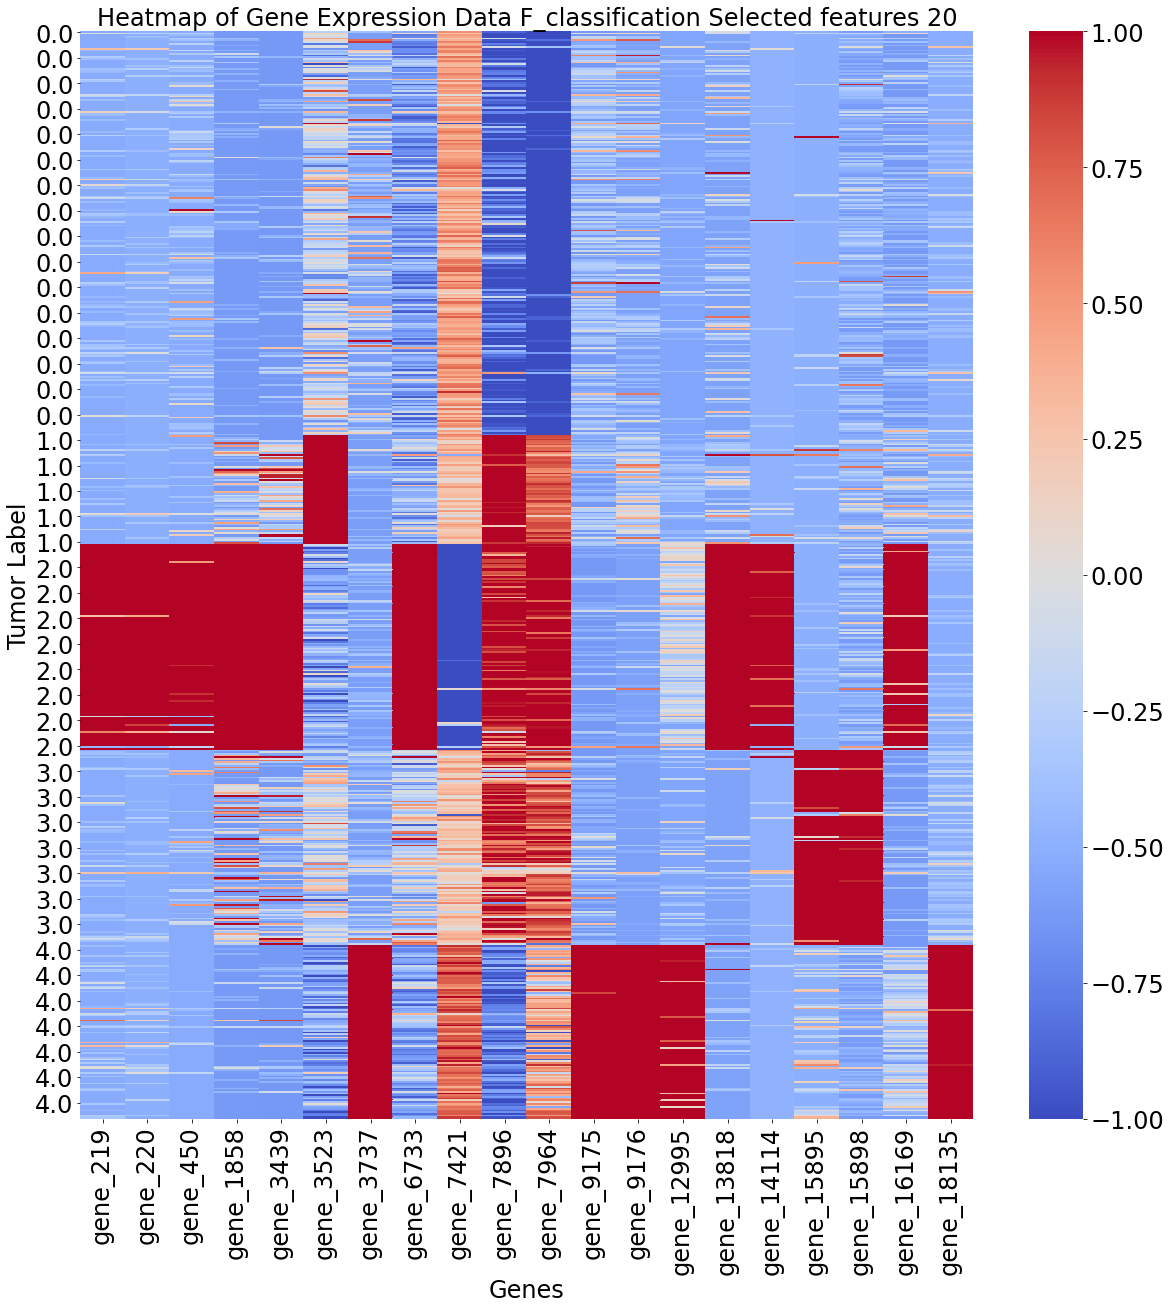

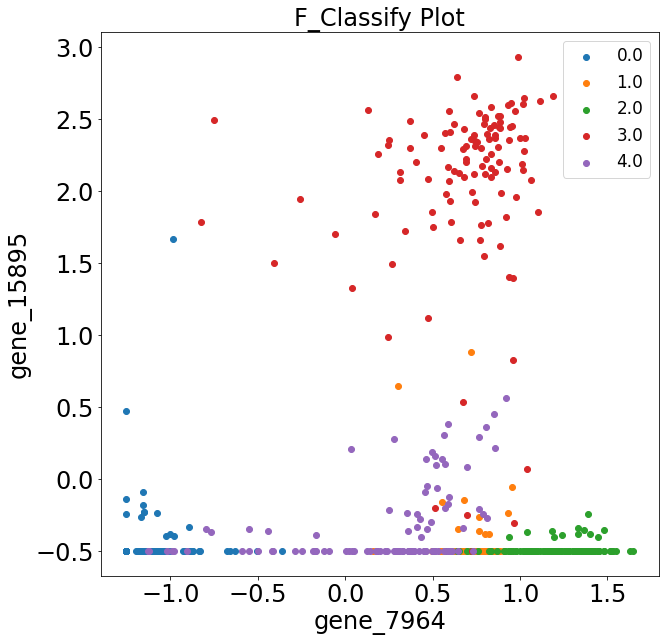

In [7]:
#f_classif two factor visualization

dualf_features,dual_fclass,_=fstat_classify(X_train,y_train,X_test,feature_names,20)

selected=['gene_7964','gene_15895']
j=np.where(np.array(dualf_features)==selected[0])[0][0]
h=np.where(np.array(dualf_features)==selected[1])[0][0]

f,ax = plt.subplots()
f.set_size_inches(10,10)
for g in np.unique(y_train.ravel()):
        i = np.where(y_train.ravel() == g)
        ax.scatter(dual_fclass[i,j], dual_fclass[i,h], label=g)

#plt.xlim(50,80)
#plt.ylim(58,62)
plt.rcParams.update({'font.size':14})
matplotlib.rc('xtick', labelsize=24)
matplotlib.rc('ytick', labelsize=24)
plt.title('F_Classify Plot',fontsize=24)

plt.xlabel(selected[0],fontsize=24)
plt.ylabel(selected[1],fontsize=24)

plt.legend(loc='best',fontsize='large')
plt.savefig('F_classify 2D plot.png', dpi=300, bbox_inches='tight')
plt.show()

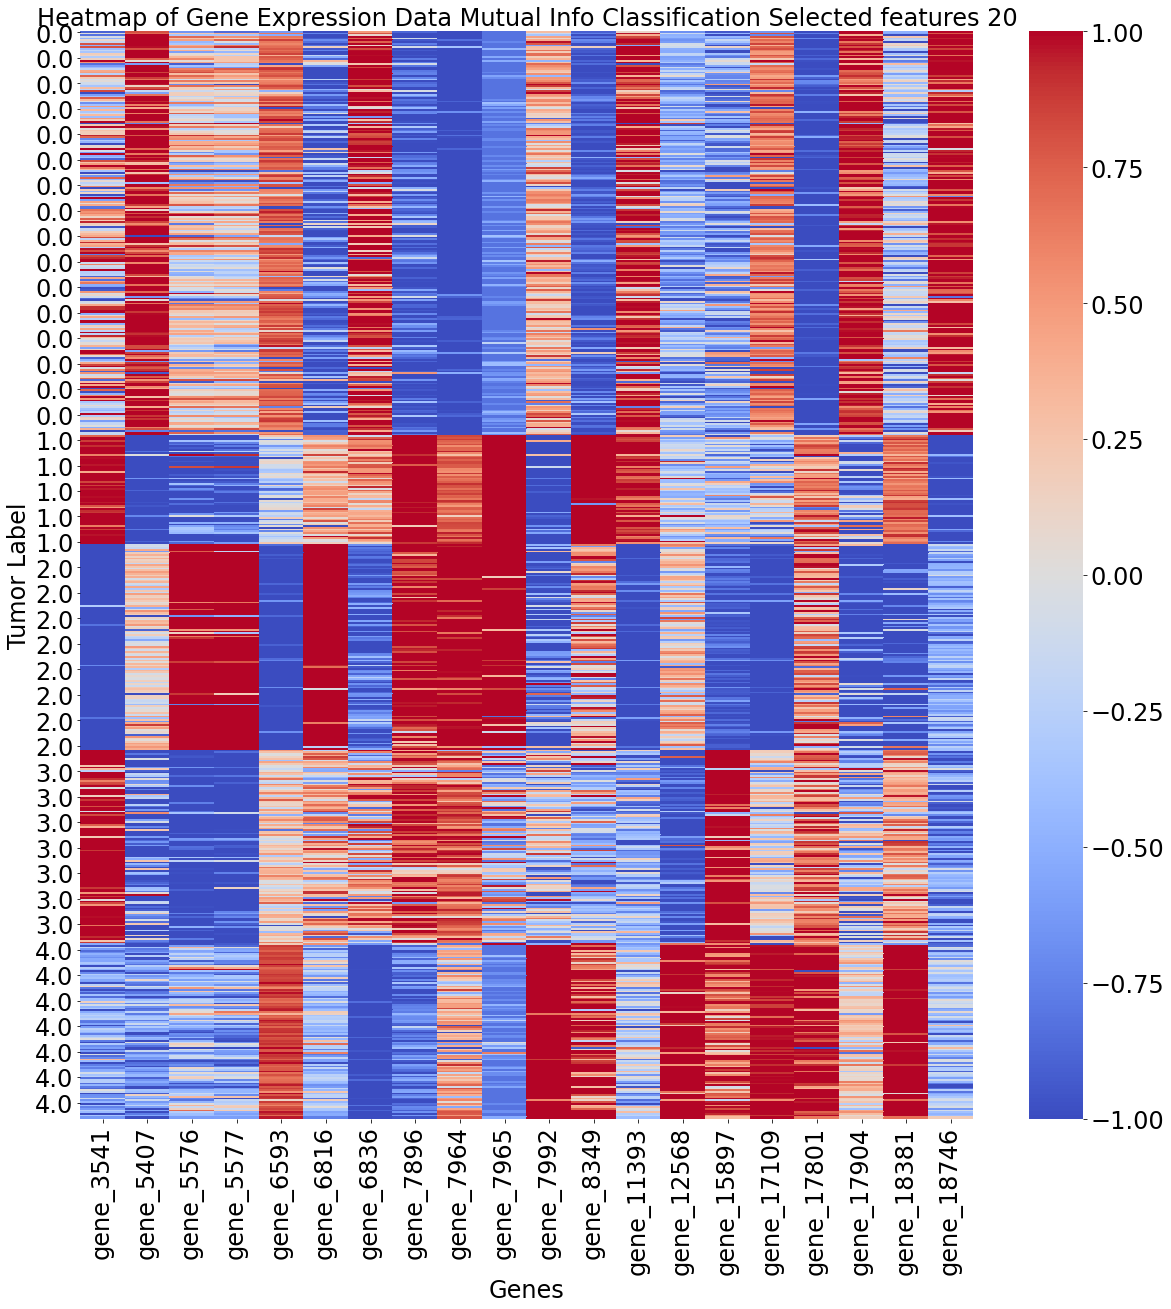

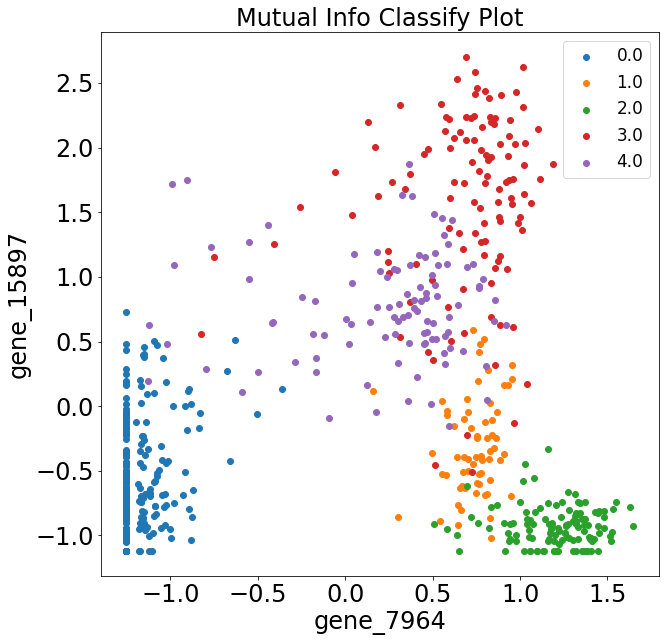

In [8]:
#multi info classification

dualm_features,dual_multiclass,_=mutualinfo_classify(X_train,y_train,X_test,feature_names,20)
selected=['gene_7964','gene_15897']
j=np.where(np.array(dualm_features)==selected[0])[0][0]
h=np.where(np.array(dualm_features)==selected[1])[0][0]

f,ax = plt.subplots()
f.set_size_inches(10,10)
for g in np.unique(y_train.ravel()):
        i = np.where(y_train.ravel() == g)
        ax.scatter(dual_multiclass[i,j], dual_multiclass[i,h], label=g)

#plt.xlim(50,80)
#plt.ylim(58,62)
plt.rcParams.update({'font.size':14})
matplotlib.rc('xtick', labelsize=24)
matplotlib.rc('ytick', labelsize=24)
plt.title('Mutual Info Classify Plot',fontsize=24)

plt.xlabel(selected[0],fontsize=24)
plt.ylabel(selected[1],fontsize=24)

plt.legend(loc='best',fontsize='large')
plt.savefig('Mutual_Info_Classify 2D Plot.png', dpi=300, bbox_inches='tight')
plt.show()

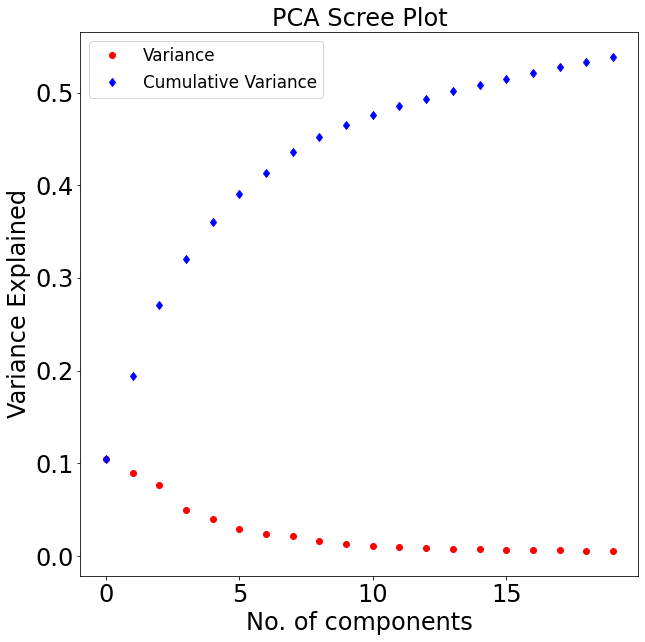

In [9]:
#PCA extraction
pca = PCA(n_components=20)
X_pc_train=pca.fit(X_train).transform(X_train)
X_pc_test=pca.fit(X_train).transform(X_test)

explained_var=pca.explained_variance_ratio_
comp=[i for i in range(len(explained_var))]
cum_var = np.cumsum(explained_var)

f,ax = plt.subplots()
f.set_size_inches(10,10)
plt.plot(comp,explained_var,'ro',label='Variance')
plt.plot(comp,cum_var,'bd',label='Cumulative Variance')
#plt.xlim(50,80)
#plt.ylim(58,62)
plt.rcParams.update({'font.size':14})
matplotlib.rc('xtick', labelsize=24)
matplotlib.rc('ytick', labelsize=24)
plt.title('PCA Scree Plot',fontsize=24)

plt.xlabel('No. of components',fontsize=24)
plt.ylabel('Variance Explained',fontsize=24)

plt.legend(loc='best',fontsize='large')
plt.savefig('PCA Scree Plot.png', dpi=300, bbox_inches='tight')
plt.show()

#X_pc_train, X_pc_test, y_pc_train, y_pc_test = train_test_split(X_pc, y, test_size=.2, random_state=2783)

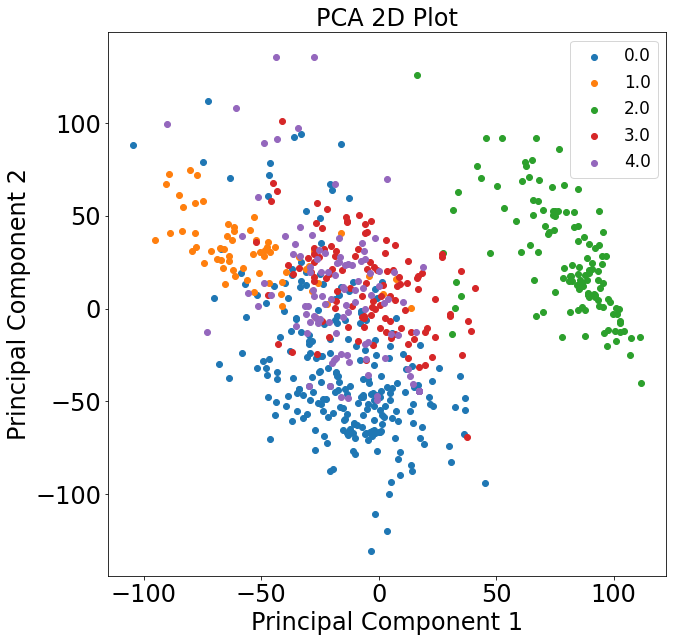

In [10]:
#PCA Plotting on first two dimensions

pca_plot = PCA(n_components=2)
X_pc_plot=pca_plot.fit_transform(X_train)

f,ax = plt.subplots()
f.set_size_inches(10,10)
for g in np.unique(y_train):
    i = np.where(y_train == g)
    ax.scatter(X_pc_plot[i,0], X_pc_plot[i,1], label=g)

#plt.xlim(50,80)
#plt.ylim(58,62)
plt.rcParams.update({'font.size':14})
matplotlib.rc('xtick', labelsize=24)
matplotlib.rc('ytick', labelsize=24)
plt.title('PCA 2D Plot',fontsize=24)

plt.xlabel('Principal Component 1',fontsize=24)
plt.ylabel('Principal Component 2',fontsize=24)

plt.legend(loc='best',fontsize='large')
plt.savefig('PCA 2D plot', dpi=300, bbox_inches='tight')
plt.show()

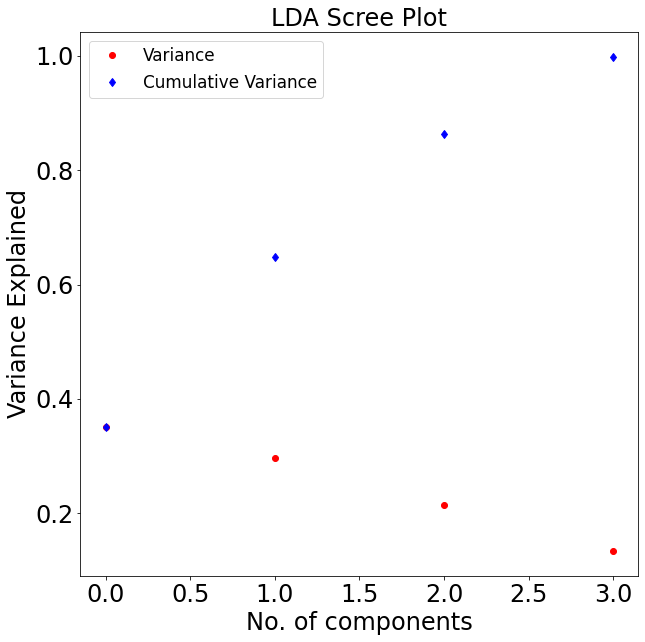

In [11]:
#Applying LDA for dimension reduction

lda = LinearDiscriminantAnalysis(n_components=4)
X_lda_train = lda.fit(X_train, y_train).transform(X_train)
X_lda_test = lda.fit(X_train, y_train).transform(X_test)

ldaexplained_var=lda.explained_variance_ratio_
ldacomp=[i for i in range(len(ldaexplained_var))]
ldacum_var = np.cumsum(ldaexplained_var)



f,ax = plt.subplots()
f.set_size_inches(10,10)
plt.plot(ldacomp,ldaexplained_var,'ro',label='Variance')
plt.plot(ldacomp,ldacum_var,'bd',label='Cumulative Variance')
#plt.xlim(50,80)
#plt.ylim(58,62)
plt.rcParams.update({'font.size':14})
matplotlib.rc('xtick', labelsize=24)
matplotlib.rc('ytick', labelsize=24)
plt.title('LDA Scree Plot',fontsize=24)

plt.xlabel('No. of components',fontsize=24)
plt.ylabel('Variance Explained',fontsize=24)

plt.legend(loc='best',fontsize='large')
plt.savefig('LDA Scree Plot.png', dpi=300, bbox_inches='tight')
plt.show()




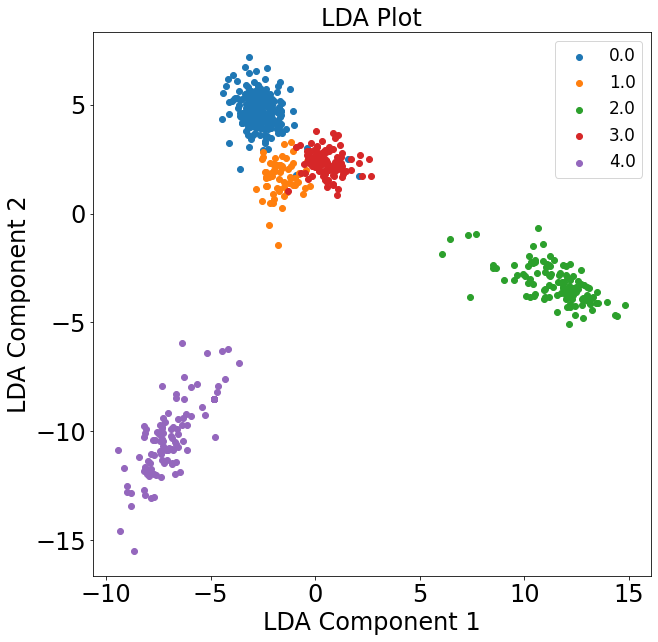

In [12]:
#LDA visualization

lda_plot = LinearDiscriminantAnalysis(n_components=2)
X_lda_plot=lda.fit(X_train, y_train).transform(X_train)

f,ax = plt.subplots()
f.set_size_inches(10,10)
for g in np.unique(y_train):
    i = np.where(y_train == g)
    ax.scatter(X_lda_plot[i,0], X_lda_plot[i,1], label=g)

#plt.xlim(50,80)
#plt.ylim(58,62)
plt.rcParams.update({'font.size':14})
matplotlib.rc('xtick', labelsize=24)
matplotlib.rc('ytick', labelsize=24)
plt.title('LDA Plot',fontsize=24)

plt.xlabel('LDA Component 1',fontsize=24)
plt.ylabel('LDA Component 2',fontsize=24)

plt.legend(loc='best',fontsize='large')
plt.savefig('LDA 2D Plot.png', dpi=300, bbox_inches='tight')
plt.show()


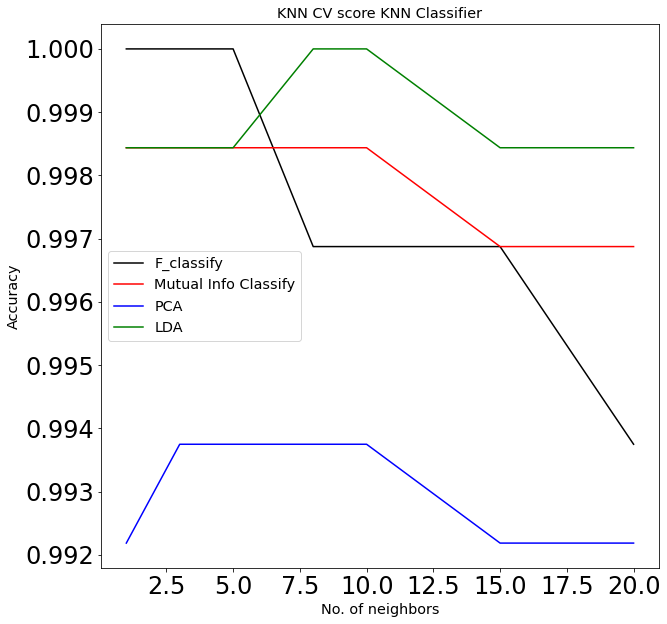

In [13]:
#k-nn for classification- tuning k

K=[1,3,5,8,10,15,20]

fclass_cv_scores=[]
mutualinfo_cv_scores=[]
pca_cv_scores=[]
lda_cv_scores=[]

for k in K:
    neigh = KNeighborsClassifier(n_neighbors=k)
    run_tuple=tuning(neigh,fclass_list[1],mutualinfo_list[1],y_train,X_pc_train,X_lda_train)
    fclass_cv_scores.append(run_tuple[0])
    mutualinfo_cv_scores.append(run_tuple[1])
    pca_cv_scores.append(run_tuple[2])
    lda_cv_scores.append(run_tuple[3])

plot_cv(K,fclass_cv_scores,mutualinfo_cv_scores,pca_cv_scores,lda_cv_scores,'KNN CV score KNN Classifier','No. of neighbors')
    
    
    
    

Model:k-nn with f_classify,Accuracy:1.0
Model: k-nn with f_classify
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        34

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



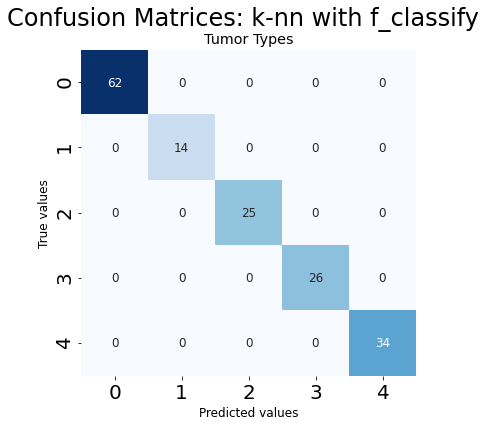

Model:k-nn with mutual info classify,Accuracy:0.9937888198757764
Model: k-nn with mutual info classify
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        25
           3       1.00      0.96      0.98        26
           4       1.00      1.00      1.00        34

    accuracy                           0.99       161
   macro avg       1.00      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



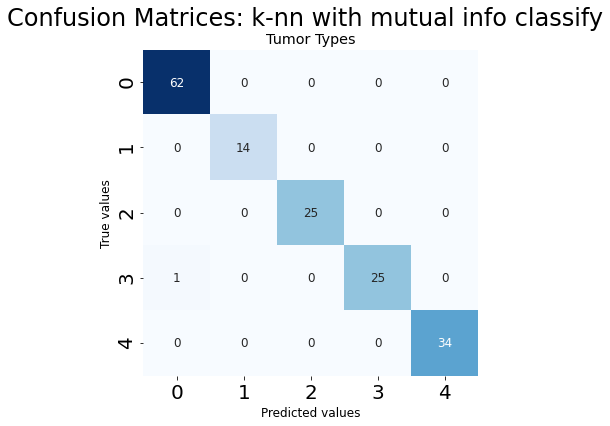

Model:k-nn with PCA,Accuracy:0.9937888198757764
Model: k-nn with PCA
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       1.00      1.00      1.00        14
           2       1.00      0.96      0.98        25
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        34

    accuracy                           0.99       161
   macro avg       1.00      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



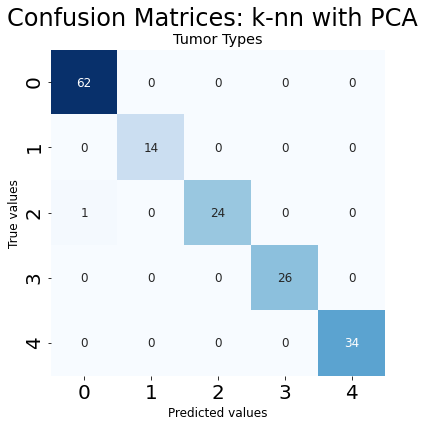

Model:k-nn with LDA,Accuracy:0.9875776397515528
Model: k-nn with LDA
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        14
           2       1.00      0.96      0.98        25
           3       1.00      0.96      0.98        26
           4       0.94      1.00      0.97        34

    accuracy                           0.99       161
   macro avg       0.99      0.98      0.99       161
weighted avg       0.99      0.99      0.99       161



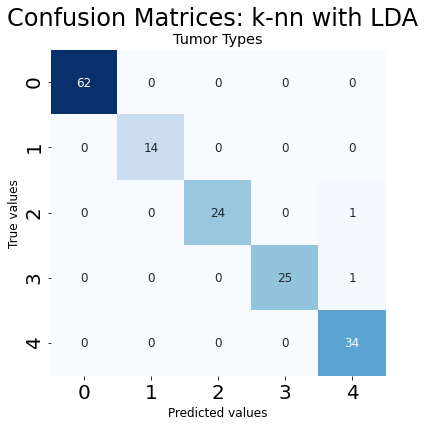

In [14]:
#fitting the best k and checking on test set

neigh=KNeighborsClassifier(n_neighbors=5)
knn_pred=calc_class_metrics(neigh,fclass_list[1],y_train,fclass_test_list[1],y_test,'k-nn with f_classify')
plot_cfmat(y_test,knn_pred,'k-nn with f_classify')

knn_pred=calc_class_metrics(neigh,mutualinfo_list[1],y_train,mutualinfo_test_list[1],y_test,'k-nn with mutual info classify')
plot_cfmat(y_test,knn_pred,'k-nn with mutual info classify')

knn_pred=calc_class_metrics(neigh,X_pc_train,y_train,X_pc_test,y_test,'k-nn with PCA')
plot_cfmat(y_test,knn_pred,'k-nn with PCA')

knn_pred=calc_class_metrics(neigh,X_lda_train,y_train,X_lda_test,y_test,'k-nn with LDA')
plot_cfmat(y_test,knn_pred,'k-nn with LDA')

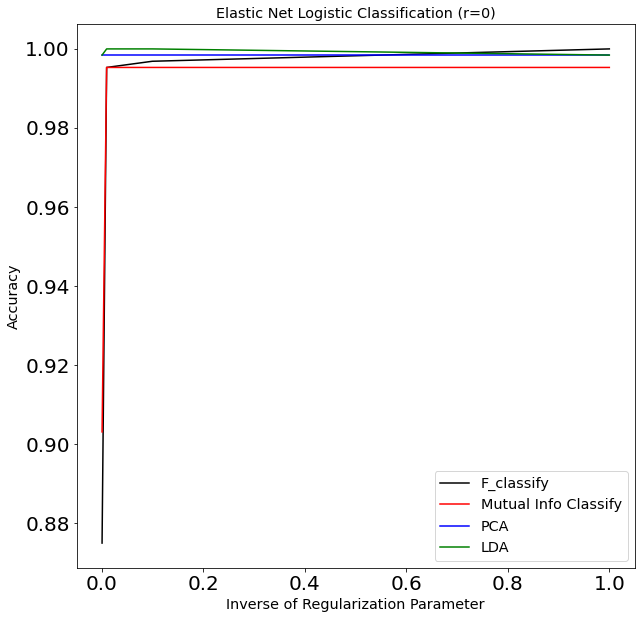

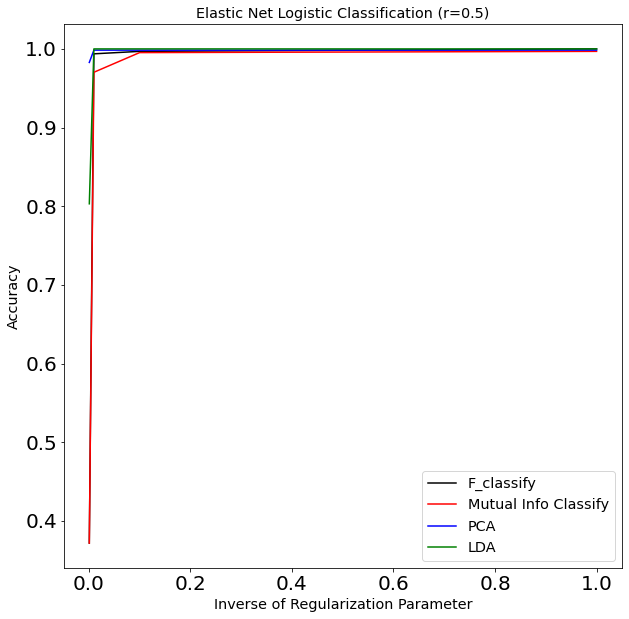

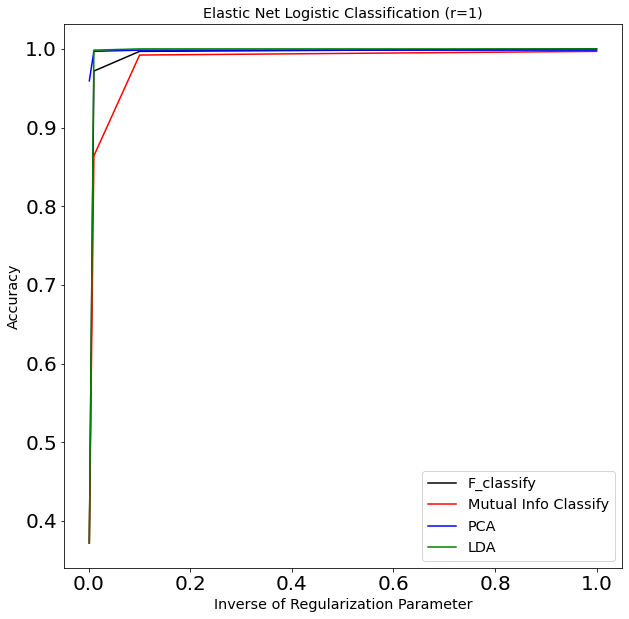

In [15]:
#logistic regression

enet_ratio=[0,0.5,1]
C=[0.001,0.01,0.1,1]

for r in enet_ratio:
    fclass_log_cv_scores=[]
    mutualinfo_log_cv_scores=[]
    pca_log_cv_scores=[]
    lda_log_cv_scores=[]
    for c in C:
        logreg=LogisticRegression(penalty='elasticnet',C=c,solver='saga',l1_ratio=r,multi_class='multinomial',max_iter=100000)
        run_tuple=tuning(logreg,fclass_list[1],mutualinfo_list[1],y_train,X_pc_train,X_lda_train)
        fclass_log_cv_scores.append(run_tuple[0])
        mutualinfo_log_cv_scores.append(run_tuple[1])
        pca_log_cv_scores.append(run_tuple[2])
        lda_log_cv_scores.append(run_tuple[3])
    plot_cv(C,fclass_log_cv_scores,mutualinfo_log_cv_scores,pca_log_cv_scores,lda_log_cv_scores,'Elastic Net Logistic Classification (r='+str(r)+')','Inverse of Regularization Parameter')

Model:Logistic Regression with f_classify,Accuracy:0.9937888198757764
Model: Logistic Regression with f_classify
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        26
           4       1.00      0.97      0.99        34

    accuracy                           0.99       161
   macro avg       1.00      0.99      1.00       161
weighted avg       0.99      0.99      0.99       161



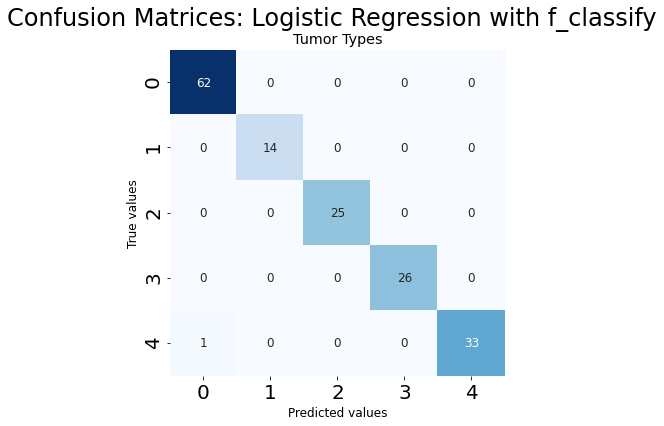

Model:Logistic Regression with mutual info classify,Accuracy:0.9937888198757764
Model: Logistic Regression with mutual info classify
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        25
           3       1.00      0.96      0.98        26
           4       1.00      1.00      1.00        34

    accuracy                           0.99       161
   macro avg       1.00      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



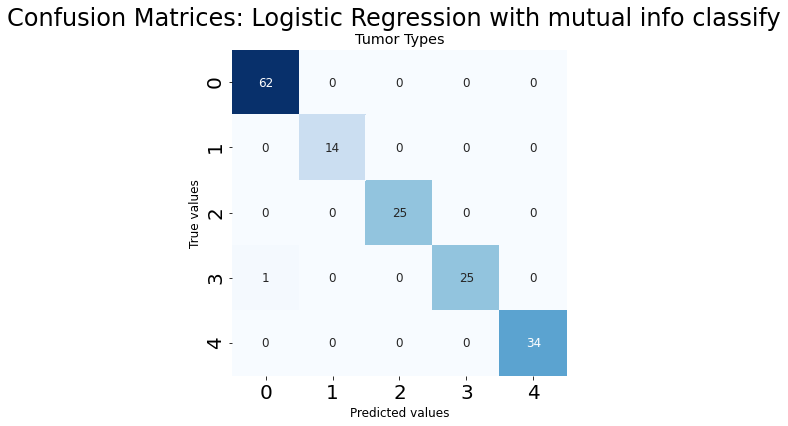

Model:Logistic Regression with PCA,Accuracy:1.0
Model: Logistic Regression with PCA
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        34

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



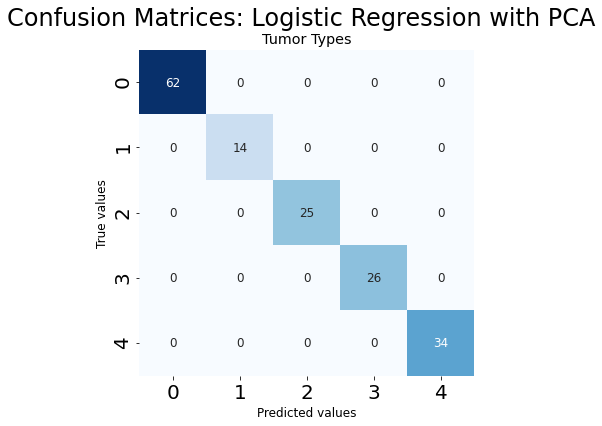

Model:Logistic Regression with LDA,Accuracy:0.9813664596273292
Model: Logistic Regression with LDA
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       0.93      1.00      0.97        14
           2       1.00      0.96      0.98        25
           3       0.96      1.00      0.98        26
           4       1.00      0.94      0.97        34

    accuracy                           0.98       161
   macro avg       0.98      0.98      0.98       161
weighted avg       0.98      0.98      0.98       161



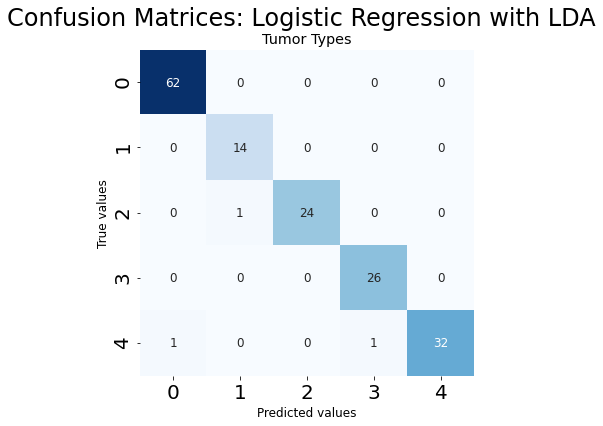

In [16]:
#fitting best logistic regression model and testing on test set

logreg=LogisticRegression(penalty='elasticnet',C=1,solver='saga',l1_ratio=0.5,multi_class='multinomial',max_iter=100000)
logreg_pred=calc_class_metrics(logreg,fclass_list[1],y_train,fclass_test_list[1],y_test,'Logistic Regression with f_classify')
plot_cfmat(y_test,logreg_pred,'Logistic Regression with f_classify')

logreg_pred=calc_class_metrics(logreg,mutualinfo_list[1],y_train,mutualinfo_test_list[1],y_test,'Logistic Regression with mutual info classify')
plot_cfmat(y_test,logreg_pred,'Logistic Regression with mutual info classify')

logreg_pred=calc_class_metrics(logreg,X_pc_train,y_train,X_pc_test,y_test,'Logistic Regression with PCA')
plot_cfmat(y_test,logreg_pred,'Logistic Regression with PCA')

logreg_pred=calc_class_metrics(logreg,X_lda_train,y_train,X_lda_test,y_test,'Logistic Regression with LDA')
plot_cfmat(y_test,logreg_pred,'Logistic Regression with LDA')

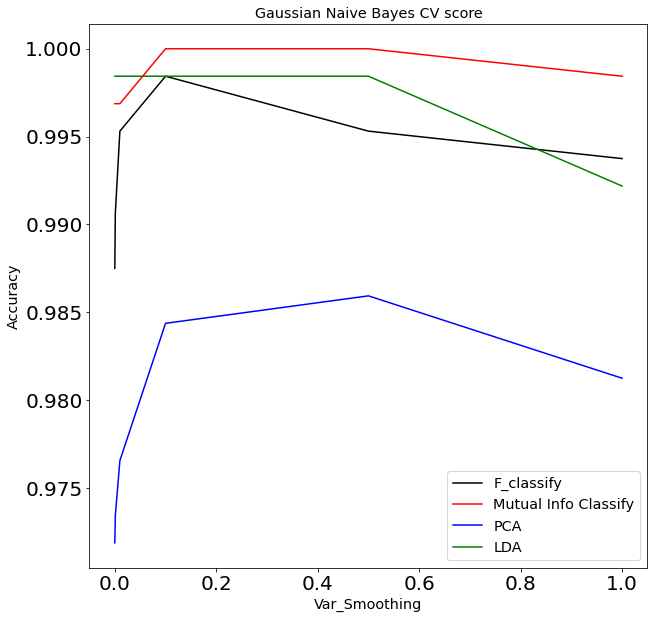

In [17]:
#Naive Bayes fitting

smooths=[1e-9,1e-6,1e-3,1e-2,0.1,0.5,1]

fclass_nb_cv_scores=[]
mutualinfo_nb_cv_scores=[]
pca_nb_cv_scores=[]
lda_nb_cv_scores=[]

for smooth in smooths:
    gaussnb=GaussianNB(var_smoothing=smooth)
    run_tuple=tuning(gaussnb,fclass_list[1],mutualinfo_list[1],y_train,X_pc_train,X_lda_train)
    fclass_nb_cv_scores.append(run_tuple[0])
    mutualinfo_nb_cv_scores.append(run_tuple[1])
    pca_nb_cv_scores.append(run_tuple[2])
    lda_nb_cv_scores.append(run_tuple[3])

plot_cv(smooths,fclass_nb_cv_scores,mutualinfo_nb_cv_scores,pca_nb_cv_scores,lda_nb_cv_scores,'Gaussian Naive Bayes CV score','Var_Smoothing')
    
    


Model:GaussNB with f_classify,Accuracy:1.0
Model: GaussNB with f_classify
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        34

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



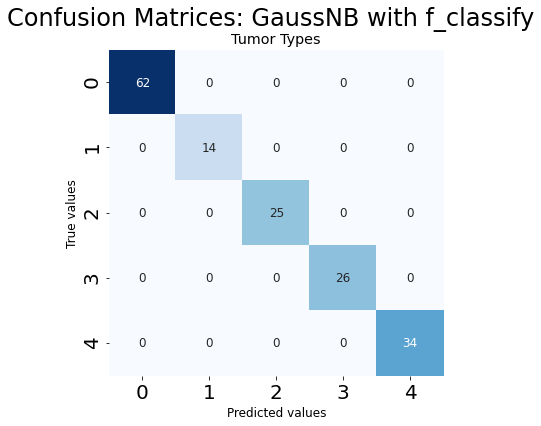

Model:GaussNB with mutual info classify,Accuracy:0.9937888198757764
Model: GaussNB with mutual info classify
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        25
           3       1.00      0.96      0.98        26
           4       1.00      1.00      1.00        34

    accuracy                           0.99       161
   macro avg       1.00      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



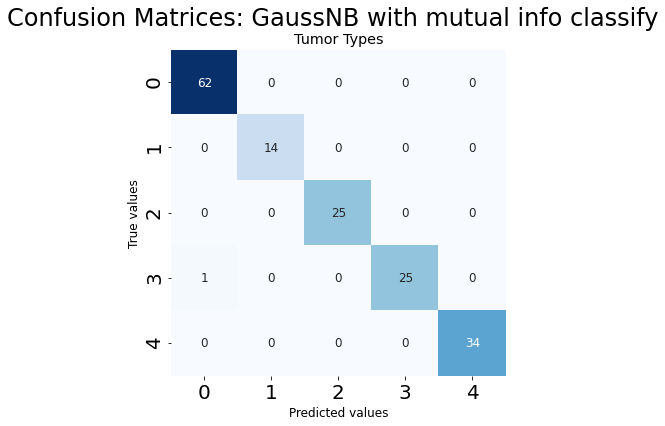

Model:GaussNB with PCA,Accuracy:0.9875776397515528
Model: GaussNB with PCA
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        62
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        25
           3       1.00      0.96      0.98        26
           4       1.00      0.97      0.99        34

    accuracy                           0.99       161
   macro avg       0.99      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



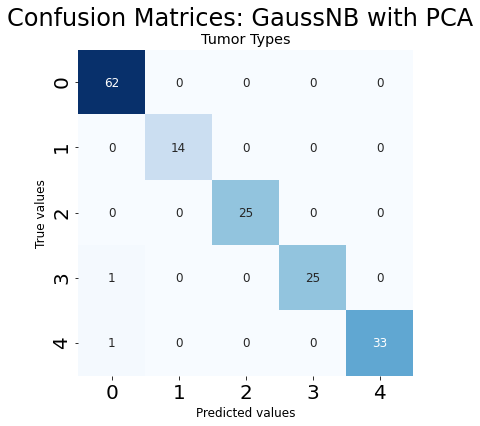

Model:GaussNB with LDA,Accuracy:0.9751552795031055
Model: GaussNB with LDA
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        62
           1       0.88      1.00      0.93        14
           2       1.00      0.96      0.98        25
           3       1.00      0.96      0.98        26
           4       0.94      0.97      0.96        34

    accuracy                           0.98       161
   macro avg       0.96      0.98      0.97       161
weighted avg       0.98      0.98      0.98       161



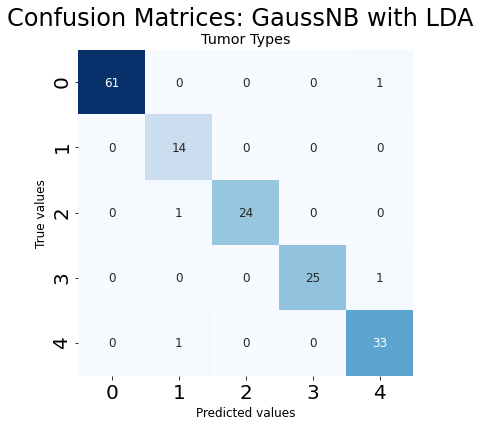

In [18]:
#naive bayes: test set

gaussnb=GaussianNB(var_smoothing=0.1)

NB_pred=calc_class_metrics(gaussnb,fclass_list[1],y_train,fclass_test_list[1],y_test,'GaussNB with f_classify')
plot_cfmat(y_test,NB_pred,'GaussNB with f_classify')

NB_pred=calc_class_metrics(gaussnb,mutualinfo_list[1],y_train,mutualinfo_test_list[1],y_test,'GaussNB with mutual info classify')
plot_cfmat(y_test,NB_pred,'GaussNB with mutual info classify')

NB_pred=calc_class_metrics(gaussnb,X_pc_train,y_train,X_pc_test,y_test,'GaussNB with PCA')
plot_cfmat(y_test,NB_pred,'GaussNB with PCA')

NB_pred=calc_class_metrics(gaussnb,X_lda_train,y_train,X_lda_test,y_test,'GaussNB with LDA')
plot_cfmat(y_test,NB_pred,'GaussNB with LDA')

By using standard scaler, all attributes have the same variance
Feature Selection or Dimensionality Reduction Method: F_Classify


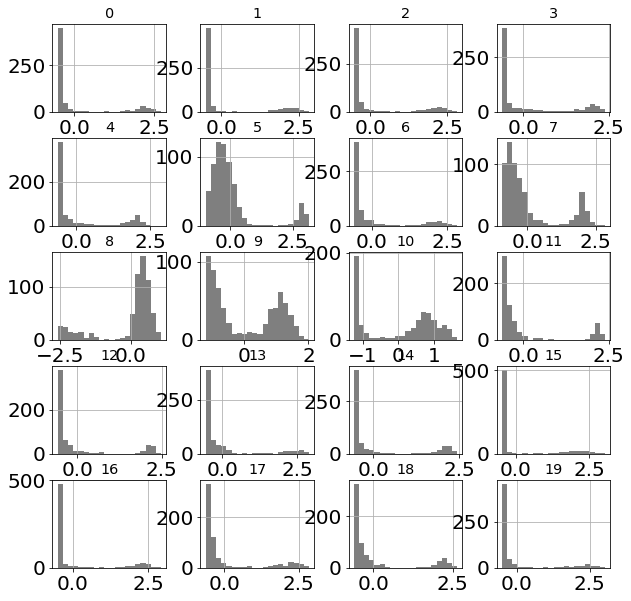

Feature Selection or Dimensionality Reduction Method: Mutual Info Classify


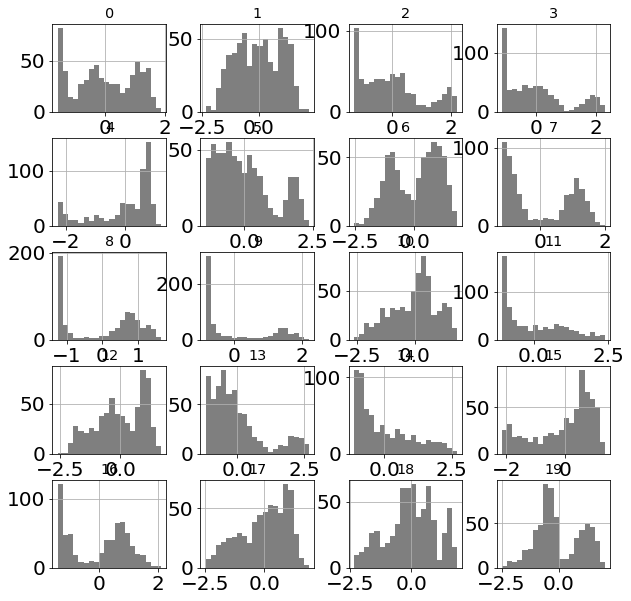

Feature Selection or Dimensionality Reduction Method: PCA


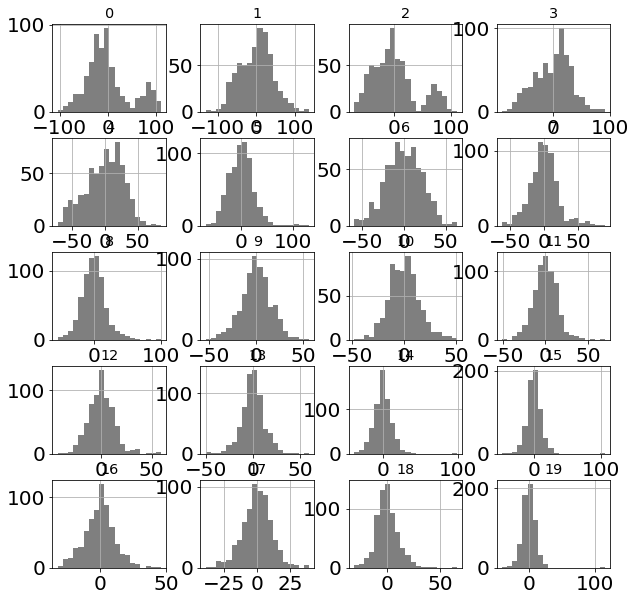

Feature Selection or Dimensionality Reduction Method: LDA


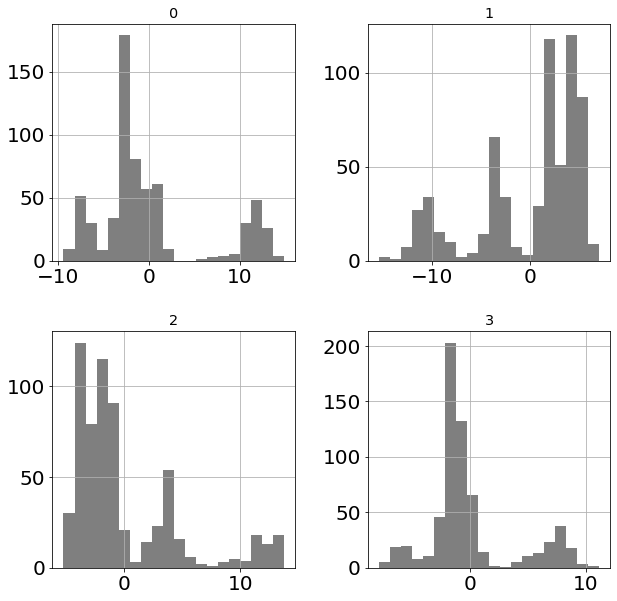

In [19]:
#Checking normality of the attributes

print ('By using standard scaler, all attributes have the same variance')

#checking if the distribution is normal

input_attributes=[fclass_list[1],mutualinfo_list[1],X_pc_train,X_lda_train]
name=['F_Classify','Mutual Info Classify','PCA','LDA']
for i in range(len(input_attributes)):
    temp_df=pd.DataFrame()
    print ('Feature Selection or Dimensionality Reduction Method: '+name[i])
    temp_df=pd.DataFrame(input_attributes[i])
    temp_df.hist(color='k', alpha=0.5, bins=20,figsize=(10,10))
    plt.show()
   

  




In [20]:
#LDA on PCA projected data

fclass_lda_cv_scores=[]
mutualinfo_lda_cv_scores=[]
pca_lda_cv_scores=[]
lda_lda_cv_scores=[]


ldaclf=LinearDiscriminantAnalysis()
run_tuple=tuning(ldaclf,fclass_list[1],mutualinfo_list[1],y_train,X_pc_train,X_lda_train)
fclass_lda_cv_scores.append(run_tuple[0])
mutualinfo_lda_cv_scores.append(run_tuple[1])
pca_lda_cv_scores.append(run_tuple[2])
lda_lda_cv_scores.append(run_tuple[3])


print ('LDA Classifier on F Classify Selection (k=20):',run_tuple[0])
print ('LDA Classifier on Mutual Info Classify Selection (k=20):',run_tuple[1])
print ('LDA Classifier on PCA Projections (20 components)',run_tuple[2])
print ('LDA Classifier on LDA Projections (4 components)',run_tuple[3])


    
    


LDA Classifier on F Classify Selection (k=20): 0.9953125
LDA Classifier on Mutual Info Classify Selection (k=20): 1.0
LDA Classifier on PCA Projections (20 components) 0.9953125
LDA Classifier on LDA Projections (4 components) 1.0


Model:LDA Classifier with f_classify,Accuracy:1.0
Model: LDA Classifier with f_classify
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        34

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



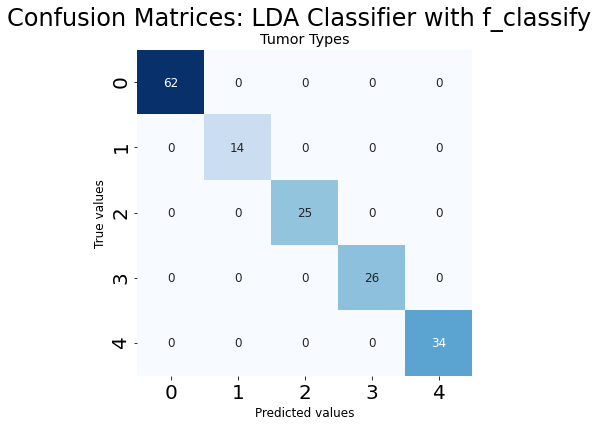

Model:LDA Classifier with mutual info classify,Accuracy:0.9937888198757764
Model: LDA Classifier with mutual info classify
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        25
           3       1.00      0.96      0.98        26
           4       1.00      1.00      1.00        34

    accuracy                           0.99       161
   macro avg       1.00      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



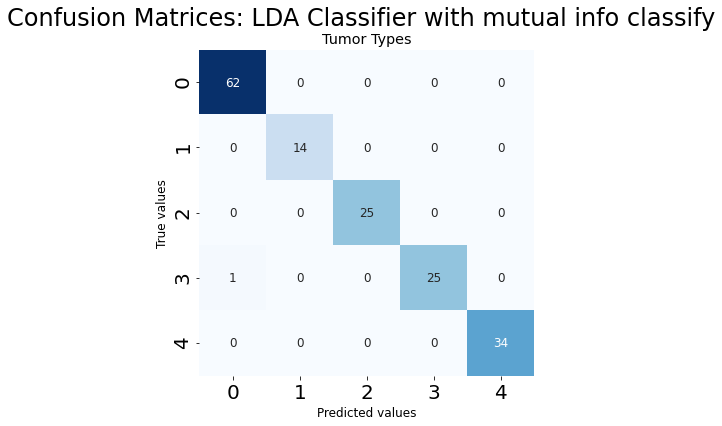

Model:LDA Classifier with PCA,Accuracy:1.0
Model: LDA Classifier with PCA
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        34

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



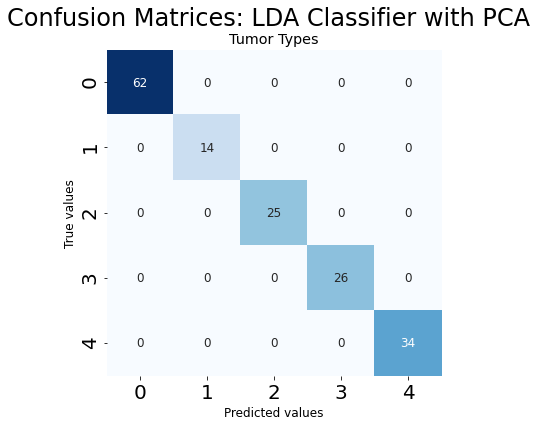

Model:LDA Classifier with LDA,Accuracy:0.9813664596273292
Model: LDA Classifier with LDA
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       0.93      1.00      0.97        14
           2       1.00      0.96      0.98        25
           3       1.00      0.96      0.98        26
           4       0.97      0.97      0.97        34

    accuracy                           0.98       161
   macro avg       0.98      0.98      0.98       161
weighted avg       0.98      0.98      0.98       161



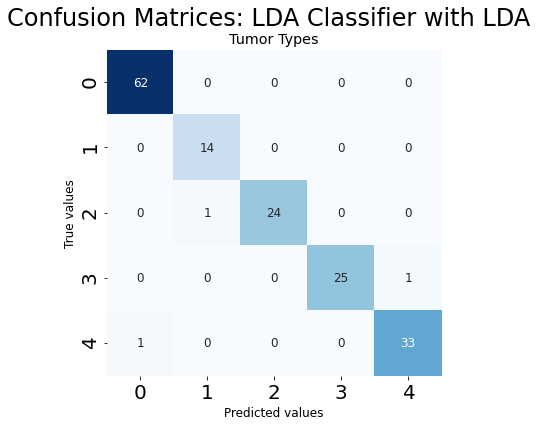

In [21]:
#LDA Classification of test set

lda_pred=calc_class_metrics(ldaclf,fclass_list[1],y_train,fclass_test_list[1],y_test,'LDA Classifier with f_classify')
plot_cfmat(y_test,lda_pred,'LDA Classifier with f_classify')

lda_pred=calc_class_metrics(ldaclf,mutualinfo_list[1],y_train,mutualinfo_test_list[1],y_test,'LDA Classifier with mutual info classify')
plot_cfmat(y_test,lda_pred,'LDA Classifier with mutual info classify')

lda_pred=calc_class_metrics(ldaclf,X_pc_train,y_train,X_pc_test,y_test,'LDA Classifier with PCA')
plot_cfmat(y_test,lda_pred,'LDA Classifier with PCA')

lda_pred=calc_class_metrics(ldaclf,X_lda_train,y_train,X_lda_test,y_test,'LDA Classifier with LDA')
plot_cfmat(y_test,lda_pred,'LDA Classifier with LDA')

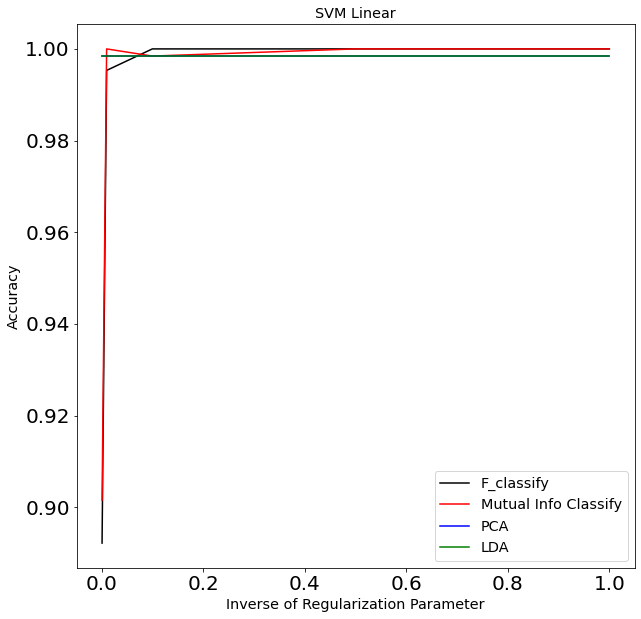

In [22]:
#SVM for classification- tuning the hyperparameters
Cs=[0.001,0.01,0.1,0.5,1]
#gamas=['scale','auto',0.01,0.1,1,10]

#sv_kernel=SVC(C=0.1,kernel='rbf',gamma=gama,decision_function_shape='ovr')

fclass_svlin_cv_scores=[]
mutualinfo_svlin_cv_scores=[]
pca_svlin_cv_scores=[]
lda_svlin_cv_scores=[]
for c in Cs:
    sv_linear=SVC(C=c,kernel='linear',decision_function_shape='ovr')
    run_tuple=tuning(sv_linear,fclass_list[1],mutualinfo_list[1],y_train,X_pc_train,X_lda_train)
    fclass_svlin_cv_scores.append(run_tuple[0])
    mutualinfo_svlin_cv_scores.append(run_tuple[1])
    pca_svlin_cv_scores.append(run_tuple[2])
    lda_svlin_cv_scores.append(run_tuple[3])
plot_cv(Cs,fclass_svlin_cv_scores,mutualinfo_svlin_cv_scores,pca_svlin_cv_scores,lda_svlin_cv_scores,'SVM Linear','Inverse of Regularization Parameter')

Model:SVM Linear with f_classify,Accuracy:1.0
Model: SVM Linear with f_classify
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        34

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



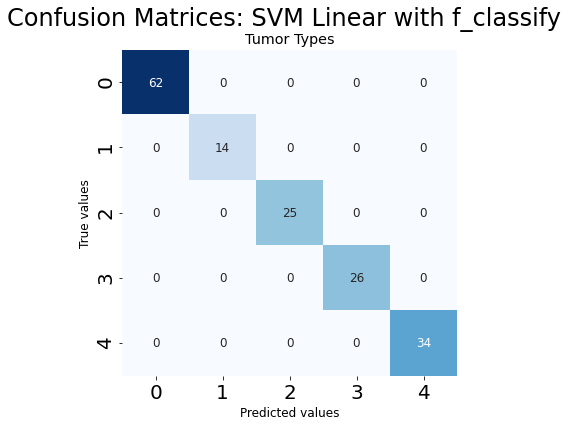

Model:SVM Linear with mutual info classify,Accuracy:0.9937888198757764
Model: SVM Linear with mutual info classify
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        25
           3       1.00      0.96      0.98        26
           4       1.00      1.00      1.00        34

    accuracy                           0.99       161
   macro avg       1.00      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



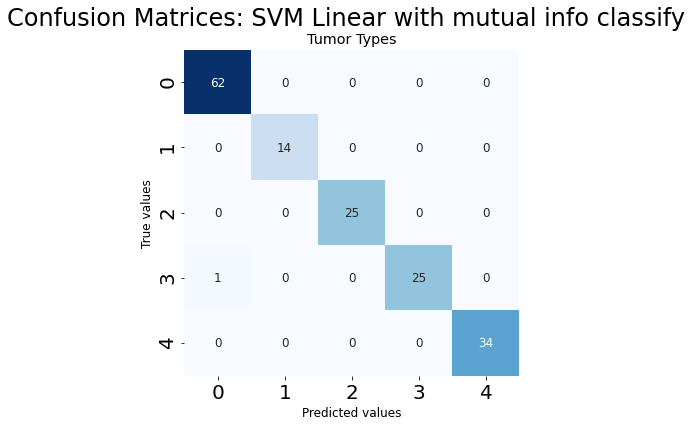

Model:SVM Linear with PCA,Accuracy:1.0
Model: SVM Linear with PCA
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        34

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



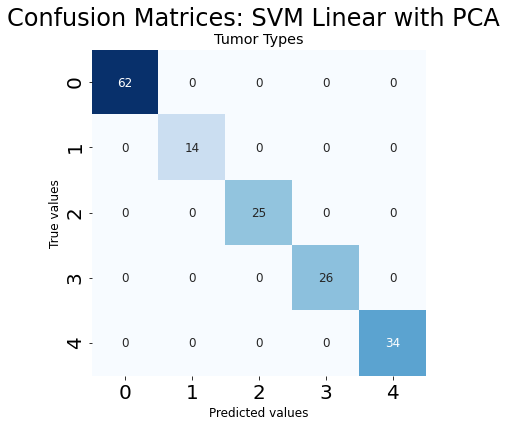

Model:SVM Linear with LDA,Accuracy:0.9813664596273292
Model: SVM Linear with LDA
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       0.93      1.00      0.97        14
           2       1.00      0.96      0.98        25
           3       1.00      0.96      0.98        26
           4       0.97      0.97      0.97        34

    accuracy                           0.98       161
   macro avg       0.98      0.98      0.98       161
weighted avg       0.98      0.98      0.98       161



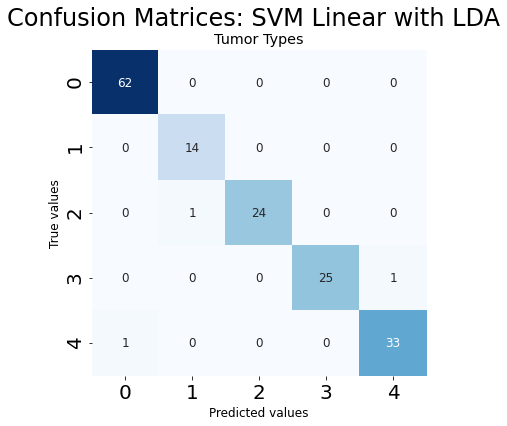

In [23]:
#Linear SVM classifier for test set

sv_linear=SVC(C=0.1,kernel='linear',decision_function_shape='ovr')
svlinear_pred=calc_class_metrics(sv_linear,fclass_list[1],y_train,fclass_test_list[1],y_test,'SVM Linear with f_classify')
plot_cfmat(y_test,svlinear_pred,'SVM Linear with f_classify')

svlinear_pred=calc_class_metrics(sv_linear,mutualinfo_list[1],y_train,mutualinfo_test_list[1],y_test,'SVM Linear with mutual info classify')
plot_cfmat(y_test,svlinear_pred,'SVM Linear with mutual info classify')

svlinear_pred=calc_class_metrics(sv_linear,X_pc_train,y_train,X_pc_test,y_test,'SVM Linear with PCA')
plot_cfmat(y_test,svlinear_pred,'SVM Linear with PCA')

svlinear_pred=calc_class_metrics(sv_linear,X_lda_train,y_train,X_lda_test,y_test,'SVM Linear with LDA')
plot_cfmat(y_test,svlinear_pred,'SVM Linear with LDA')

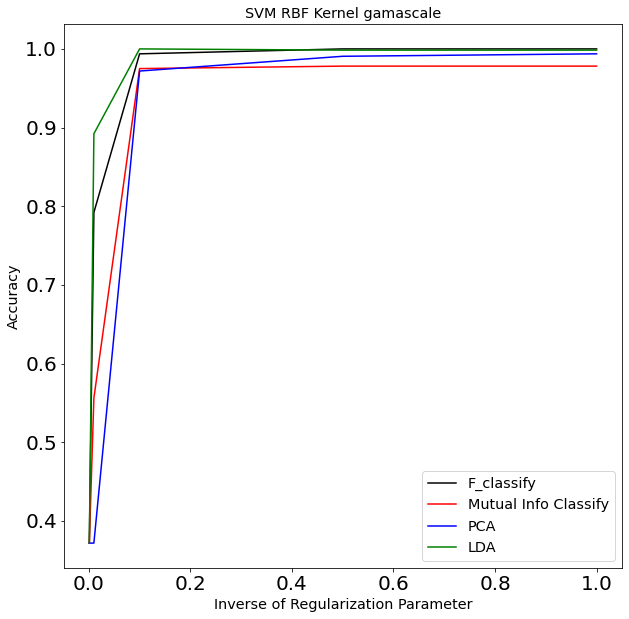

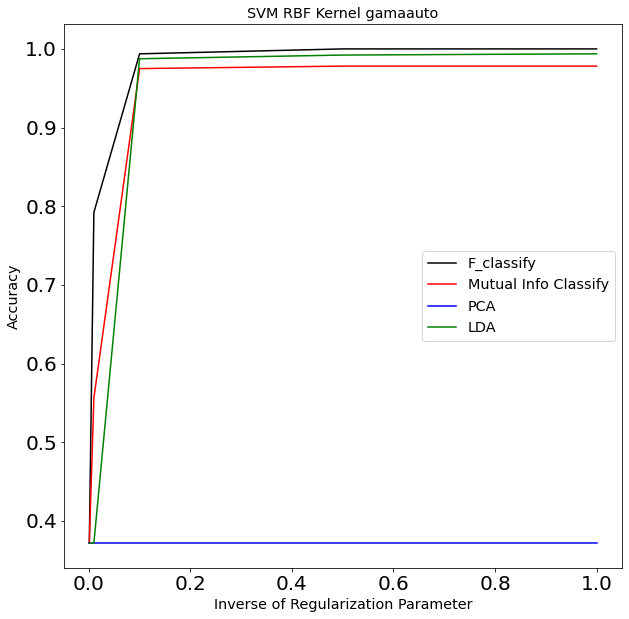

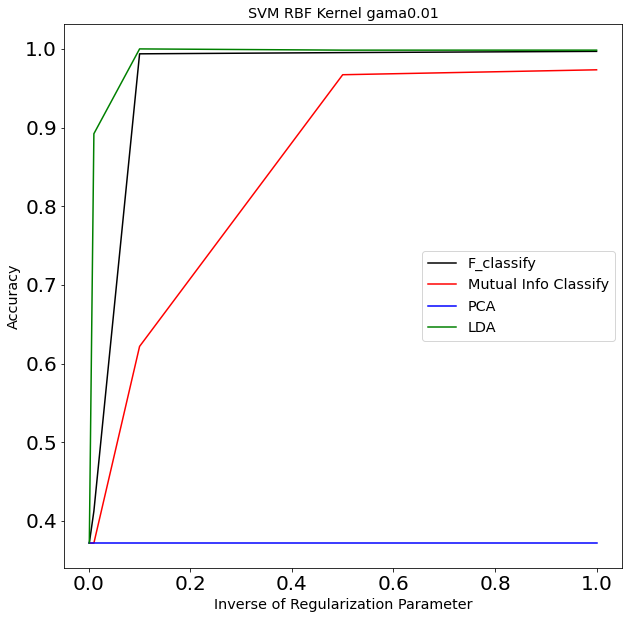

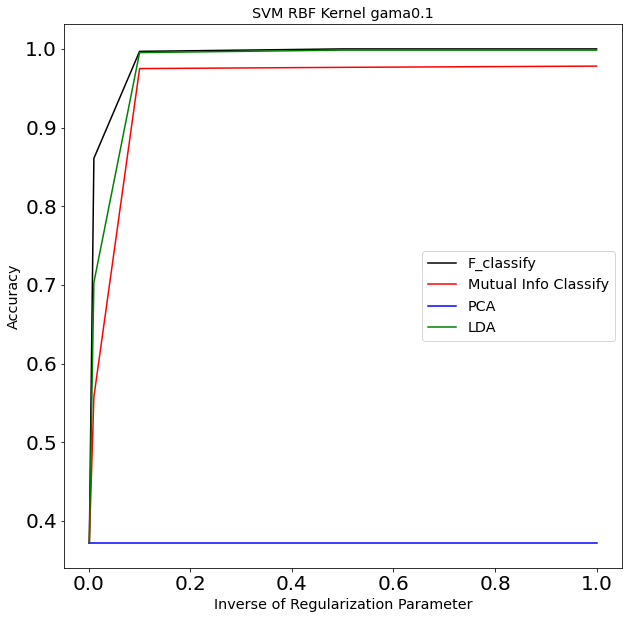

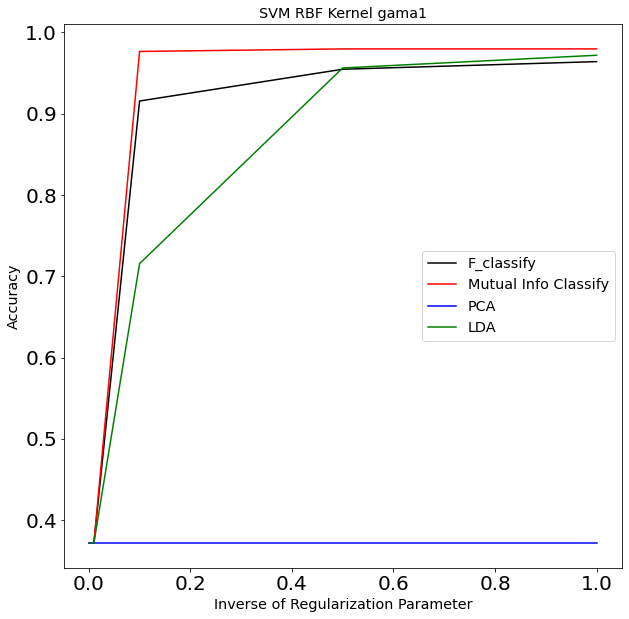

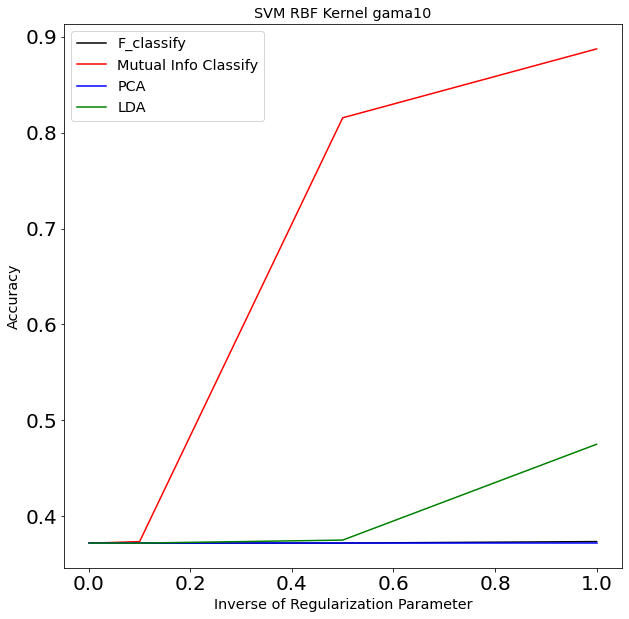

In [24]:
#tuning parameters for Kernel SVM
Cs=[0.001,0.01,0.1,0.5,1]
gamas=['scale','auto',0.01,0.1,1,10]

for gama in gamas:
    fclass_svker_cv_scores=[]
    mutualinfo_svker_cv_scores=[]
    pca_svker_cv_scores=[]
    lda_svker_cv_scores=[]
    for c in Cs:
        sv_kernel=SVC(C=c,kernel='rbf',gamma=gama,decision_function_shape='ovr')
        run_tuple=tuning(sv_kernel,fclass_list[1],mutualinfo_list[0],y_train,X_pc_train,X_lda_train)
        fclass_svker_cv_scores.append(run_tuple[0])
        mutualinfo_svker_cv_scores.append(run_tuple[1])
        pca_svker_cv_scores.append(run_tuple[2])
        lda_svker_cv_scores.append(run_tuple[3])
    plot_cv(Cs,fclass_svker_cv_scores,mutualinfo_svker_cv_scores,pca_svker_cv_scores,lda_svker_cv_scores,'SVM RBF Kernel gama'+str(gama),'Inverse of Regularization Parameter')


Model:SVM RBF Kernel with f_classify,Accuracy:1.0
Model: SVM RBF Kernel with f_classify
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        34

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



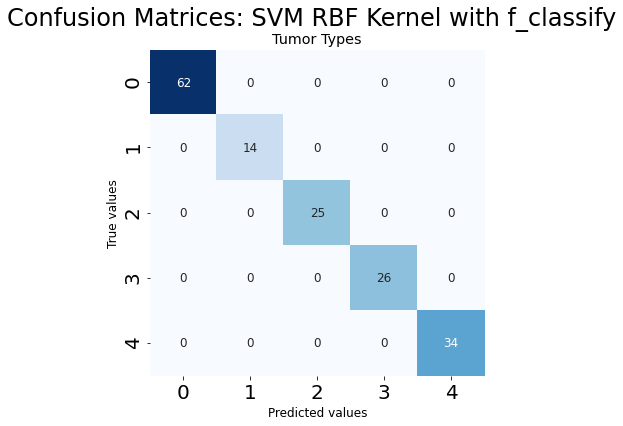

Model:SVM RBF Kernel with mutual info classify,Accuracy:0.9937888198757764
Model: SVM RBF Kernel with mutual info classify
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        25
           3       1.00      0.96      0.98        26
           4       1.00      1.00      1.00        34

    accuracy                           0.99       161
   macro avg       1.00      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



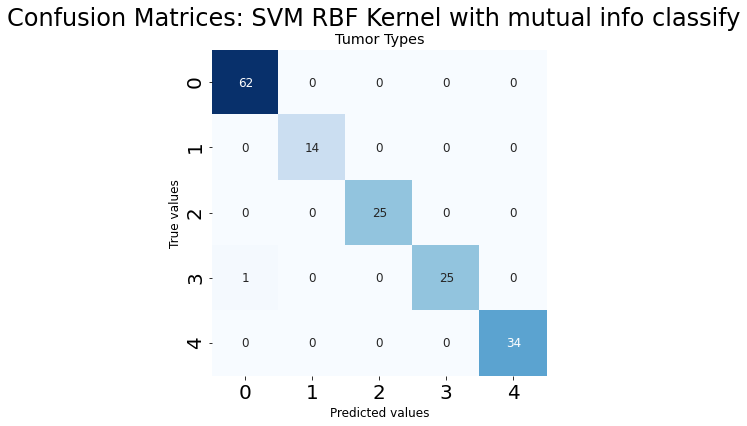

Model:SVM RBF Kernel with PCA,Accuracy:0.968944099378882
Model: SVM RBF Kernel with PCA
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        62
           1       1.00      1.00      1.00        14
           2       1.00      0.96      0.98        25
           3       1.00      0.88      0.94        26
           4       1.00      0.97      0.99        34

    accuracy                           0.97       161
   macro avg       0.99      0.96      0.97       161
weighted avg       0.97      0.97      0.97       161



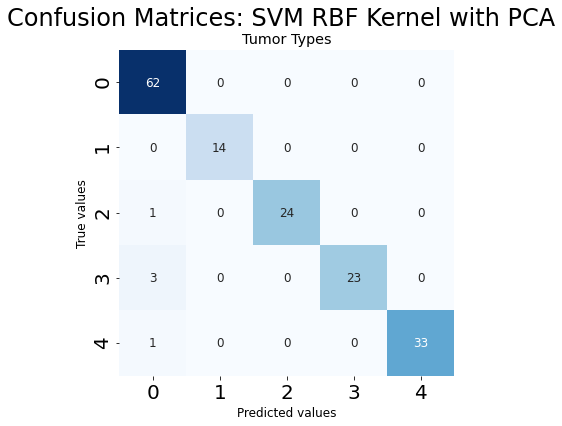

Model:SVM RBF Kernel with LDA,Accuracy:0.9751552795031055
Model: SVM RBF Kernel with LDA
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        62
           1       1.00      1.00      1.00        14
           2       1.00      0.96      0.98        25
           3       0.87      1.00      0.93        26
           4       1.00      0.94      0.97        34

    accuracy                           0.98       161
   macro avg       0.97      0.98      0.97       161
weighted avg       0.98      0.98      0.98       161



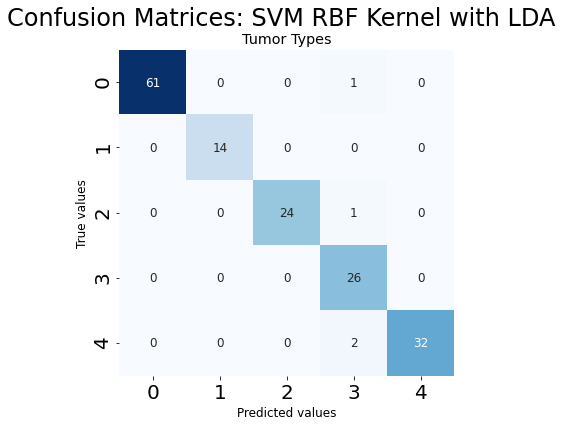

In [25]:
#svm kernel performance on test set

sv_kernel=SVC(C=0.1,kernel='rbf',gamma='scale',decision_function_shape='ovr')
svkernel_pred=calc_class_metrics(sv_kernel,fclass_list[1],y_train,fclass_test_list[1],y_test,'SVM RBF Kernel with f_classify')
plot_cfmat(y_test,svkernel_pred,'SVM RBF Kernel with f_classify')

svkernel_pred=calc_class_metrics(sv_kernel,mutualinfo_list[1],y_train,mutualinfo_test_list[1],y_test,'SVM RBF Kernel with mutual info classify')
plot_cfmat(y_test,svkernel_pred,'SVM RBF Kernel with mutual info classify')

svkernel_pred=calc_class_metrics(sv_kernel,X_pc_train,y_train,X_pc_test,y_test,'SVM RBF Kernel with PCA')
plot_cfmat(y_test,svkernel_pred,'SVM RBF Kernel with PCA')

svkernel_pred=calc_class_metrics(sv_kernel,X_lda_train,y_train,X_lda_test,y_test,'SVM RBF Kernel with LDA')
plot_cfmat(y_test,svkernel_pred,'SVM RBF Kernel with LDA')

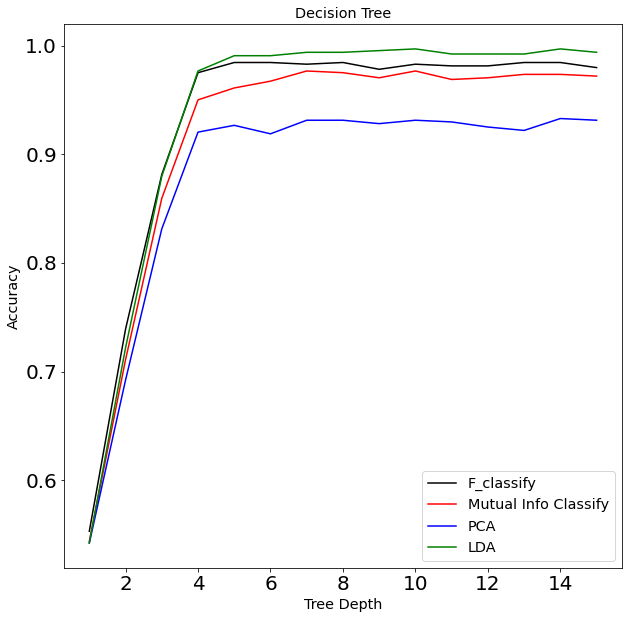

In [26]:
###### Decision Tree : Hyperparameter tuning

max_depth=[x+1 for x in range(15)]

fclass_dt_cv_scores=[]
mutualinfo_dt_cv_scores=[]
pca_dt_cv_scores=[]
lda_dt_cv_scores=[]

for depth in max_depth:
    dt_cart=DecisionTreeClassifier(max_depth=depth)
    run_tuple=tuning(dt_cart,fclass_list[1],mutualinfo_list[1],y_train,X_pc_train,X_lda_train)
    fclass_dt_cv_scores.append(run_tuple[0])
    mutualinfo_dt_cv_scores.append(run_tuple[1])
    pca_dt_cv_scores.append(run_tuple[2])
    lda_dt_cv_scores.append(run_tuple[3])
    
plot_cv(max_depth,fclass_dt_cv_scores,mutualinfo_dt_cv_scores,pca_dt_cv_scores,lda_dt_cv_scores,'Decision Tree','Tree Depth')


Model:Decision Tree with f_classify,Accuracy:0.9627329192546584
Model: Decision Tree with f_classify
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        62
           1       0.93      1.00      0.97        14
           2       1.00      0.88      0.94        25
           3       0.89      0.96      0.93        26
           4       1.00      0.94      0.97        34

    accuracy                           0.96       161
   macro avg       0.96      0.96      0.96       161
weighted avg       0.96      0.96      0.96       161



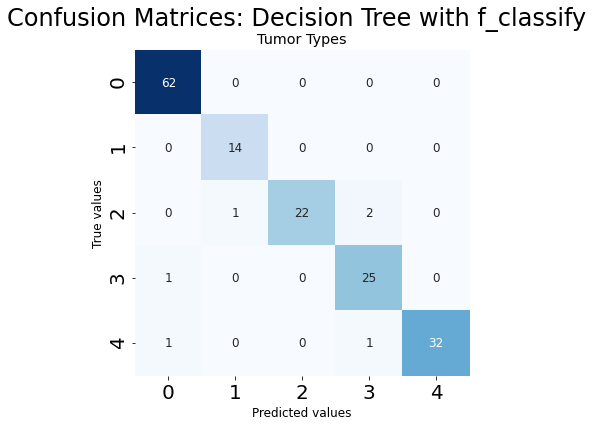

Model:Decision Tree with mutual info classify,Accuracy:0.9627329192546584
Model: Decision Tree with mutual info classify
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        62
           1       1.00      1.00      1.00        14
           2       0.92      0.92      0.92        25
           3       0.96      0.92      0.94        26
           4       0.97      0.94      0.96        34

    accuracy                           0.96       161
   macro avg       0.96      0.96      0.96       161
weighted avg       0.96      0.96      0.96       161



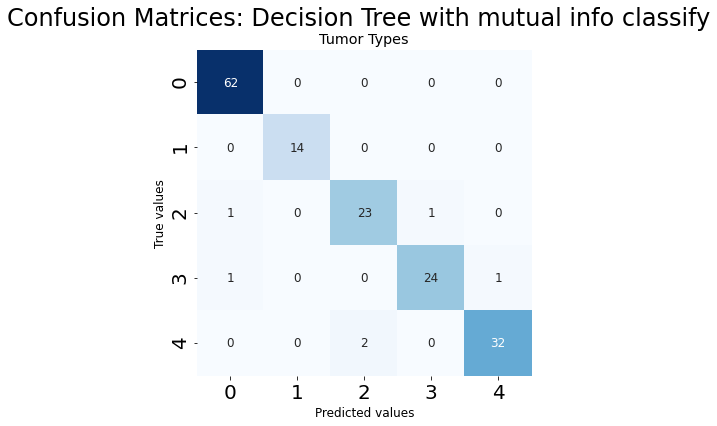

Model:Decision Tree with PCA,Accuracy:0.9192546583850931
Model: Decision Tree with PCA
              precision    recall  f1-score   support

           0       0.91      0.94      0.92        62
           1       0.88      1.00      0.93        14
           2       0.92      0.92      0.92        25
           3       0.91      0.81      0.86        26
           4       0.97      0.94      0.96        34

    accuracy                           0.92       161
   macro avg       0.92      0.92      0.92       161
weighted avg       0.92      0.92      0.92       161



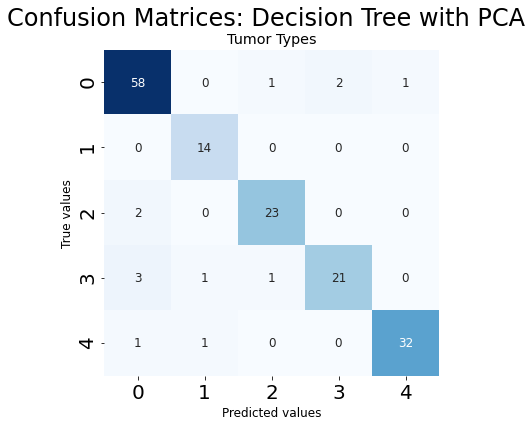

Model:Decision Tree with LDA,Accuracy:0.968944099378882
Model: Decision Tree with LDA
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        62
           1       0.93      1.00      0.97        14
           2       0.92      0.96      0.94        25
           3       1.00      0.96      0.98        26
           4       1.00      0.91      0.95        34

    accuracy                           0.97       161
   macro avg       0.97      0.97      0.97       161
weighted avg       0.97      0.97      0.97       161



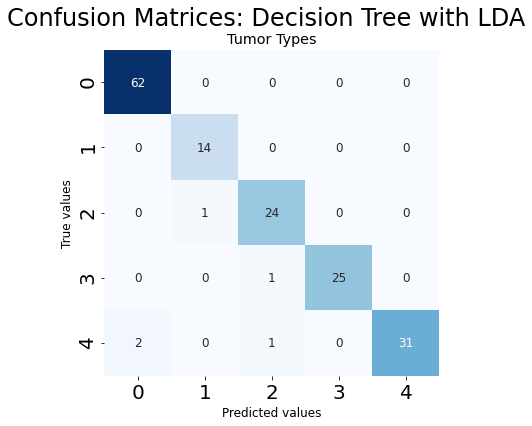

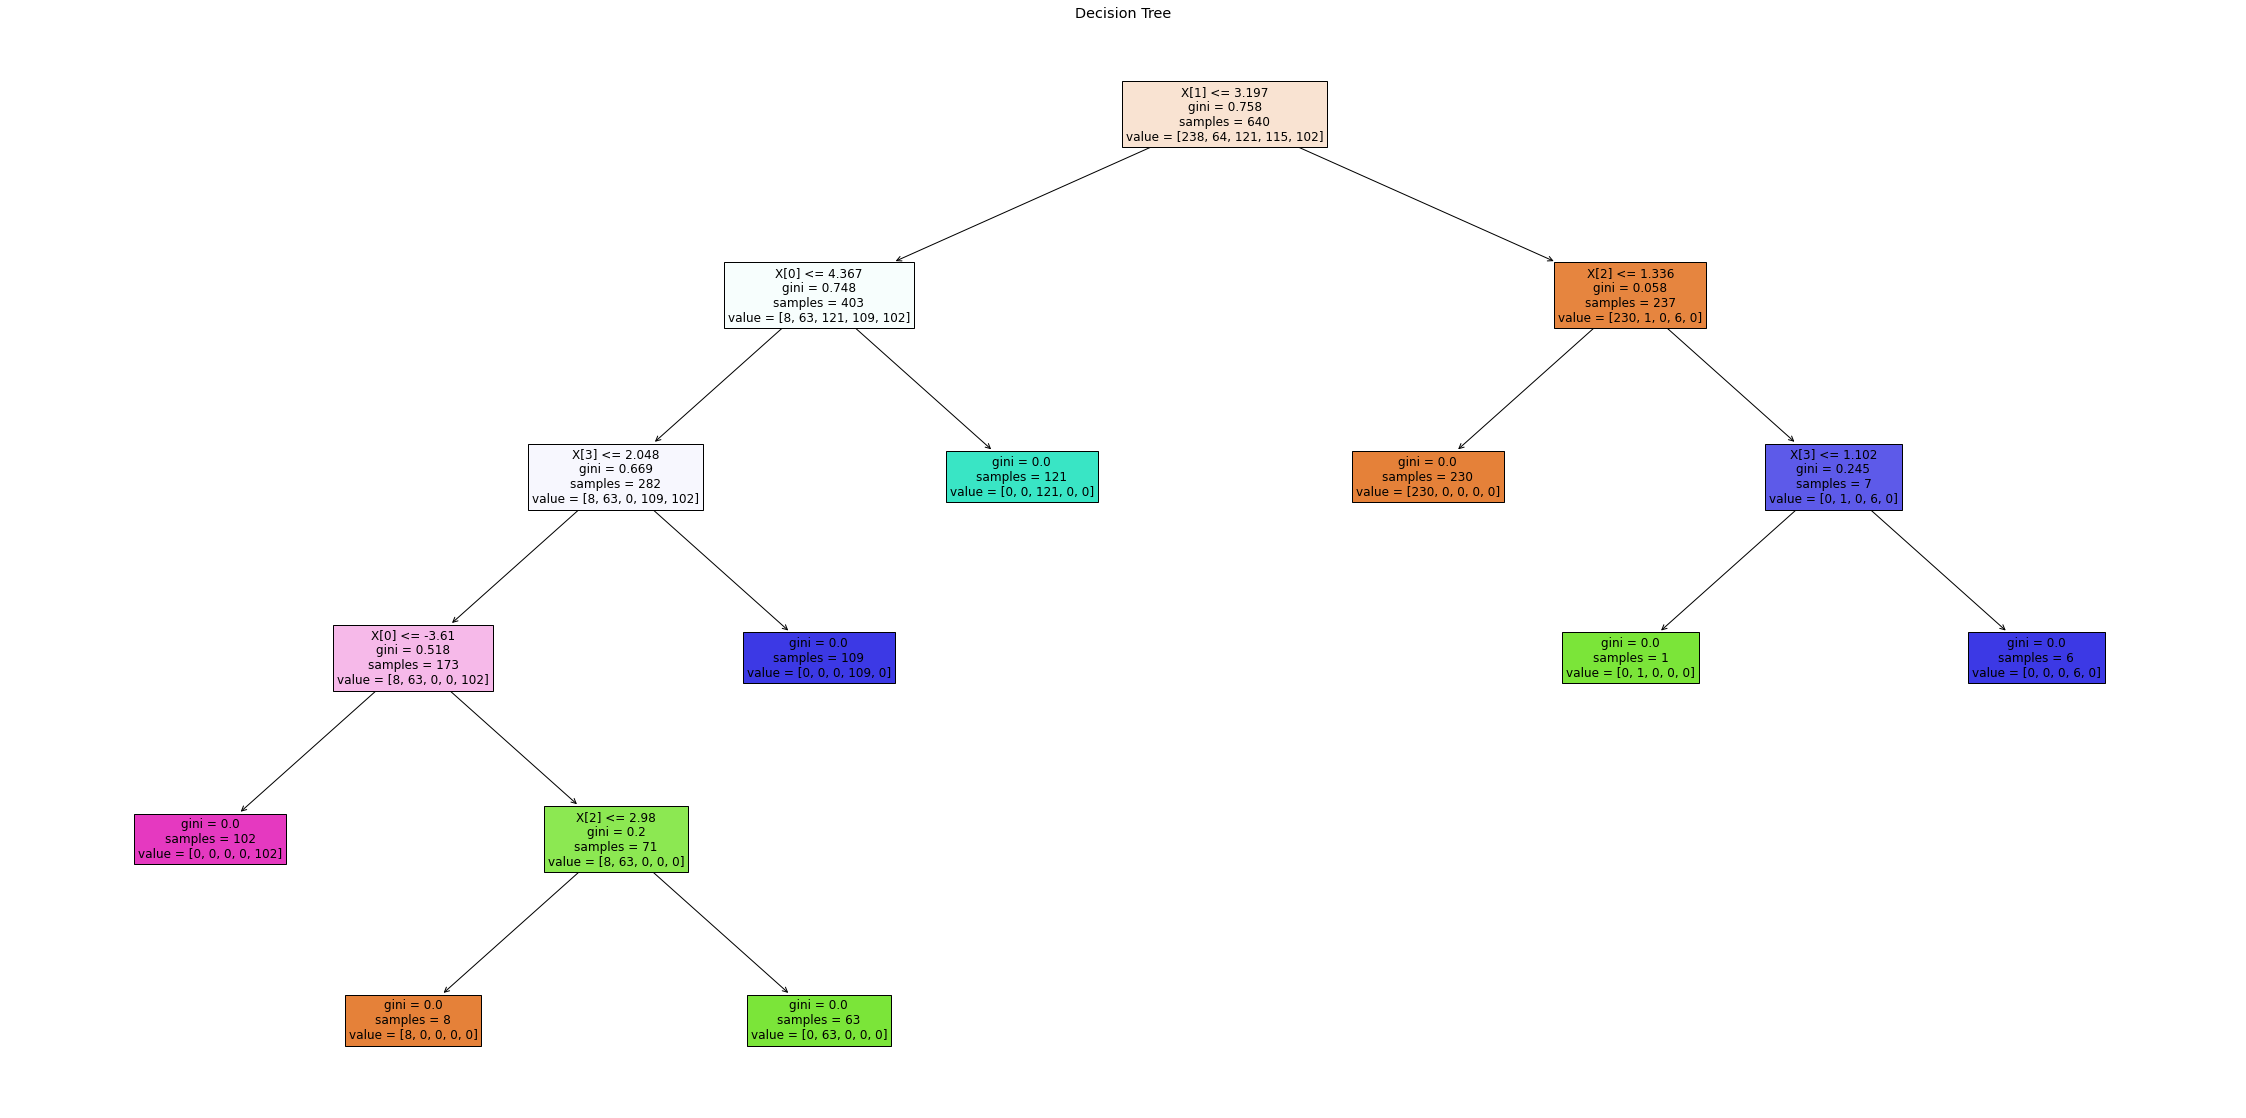

In [27]:
#Decision Tree: Performance on Test Set

dt_cart=DecisionTreeClassifier(max_depth=6)

dtcart_pred=calc_class_metrics(dt_cart,fclass_list[1],y_train,fclass_test_list[1],y_test,'Decision Tree with f_classify')
plot_cfmat(y_test,dtcart_pred,'Decision Tree with f_classify')

dtcart_pred=calc_class_metrics(dt_cart,mutualinfo_list[1],y_train,mutualinfo_test_list[1],y_test,'Decision Tree with mutual info classify')
plot_cfmat(y_test,dtcart_pred,'Decision Tree with mutual info classify')

dtcart_pred=calc_class_metrics(dt_cart,X_pc_train,y_train,X_pc_test,y_test,'Decision Tree with PCA')
plot_cfmat(y_test,dtcart_pred,'Decision Tree with PCA')

dtcart_pred=calc_class_metrics(dt_cart,X_lda_train,y_train,X_lda_test,y_test,'Decision Tree with LDA')
plot_cfmat(y_test,dtcart_pred,'Decision Tree with LDA')


#Plotting the tree

f,ax = plt.subplots()
f.set_size_inches(40,20)

plot_tree(dt_cart,filled=True,fontsize=12)
plt.title('Decision Tree')
plt.show()   

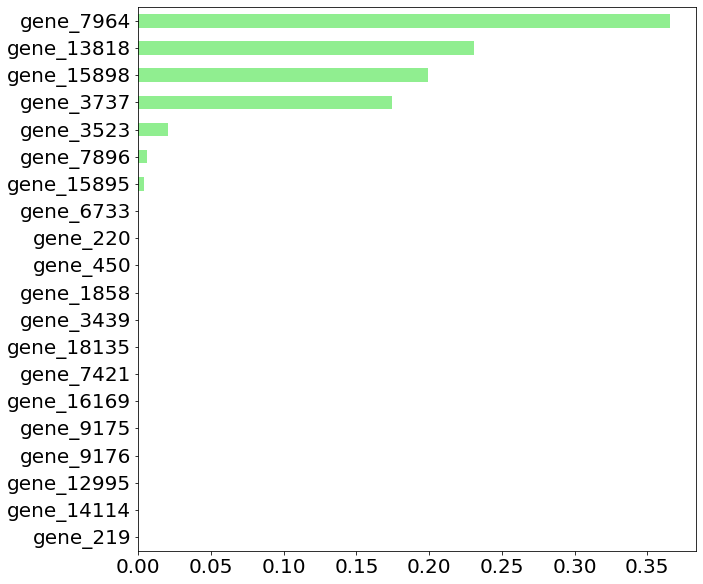

In [28]:
#decision tree feature importance
dt_cart=DecisionTreeClassifier(max_depth=6)
dt_cart.fit(fclass_list[1],y_train)
importance_dt=pd.Series(dt_cart.feature_importances_,index=fclass_name[1])
sorted_importance_dt=importance_dt.sort_values()

f,ax = plt.subplots()
f.set_size_inches(10,10)
sorted_importance_dt.plot(kind='barh',color='lightgreen')
plt.show()

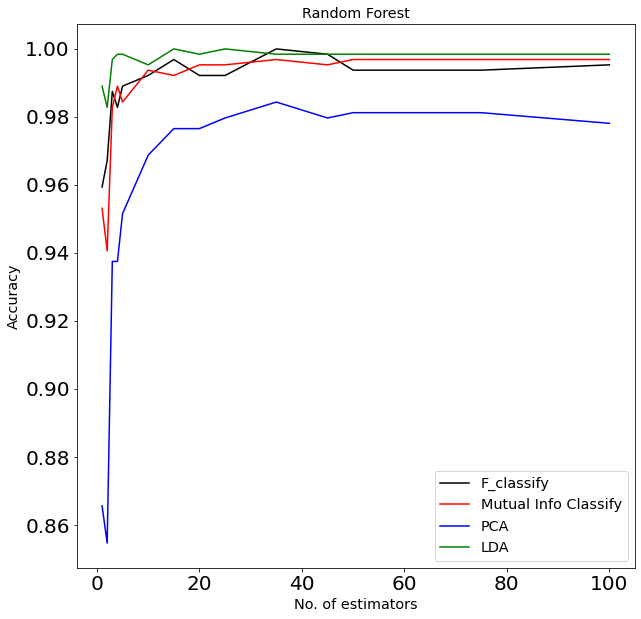

In [29]:
#Random Forest :tuning no. of trees

trees=[1,2,3,4,5,10,15,20,25,35,45,50,75,100]

fclass_rf_cv_scores=[]
mutualinfo_rf_cv_scores=[]
pca_rf_cv_scores=[]
lda_rf_cv_scores=[]

for tree in trees:
    rf=RandomForestClassifier(n_estimators=tree,max_features='sqrt')
    run_tuple=tuning(rf,fclass_list[1],mutualinfo_list[1],y_train,X_pc_train,X_lda_train)
    fclass_rf_cv_scores.append(run_tuple[0])
    mutualinfo_rf_cv_scores.append(run_tuple[1])
    pca_rf_cv_scores.append(run_tuple[2])
    lda_rf_cv_scores.append(run_tuple[3])
    
plot_cv(trees,fclass_rf_cv_scores,mutualinfo_rf_cv_scores,pca_rf_cv_scores,lda_rf_cv_scores,'Random Forest','No. of estimators')


Model:Random Forest with f_classify,Accuracy:0.9937888198757764
Model: Random Forest with f_classify
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        25
           3       1.00      0.96      0.98        26
           4       1.00      1.00      1.00        34

    accuracy                           0.99       161
   macro avg       1.00      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



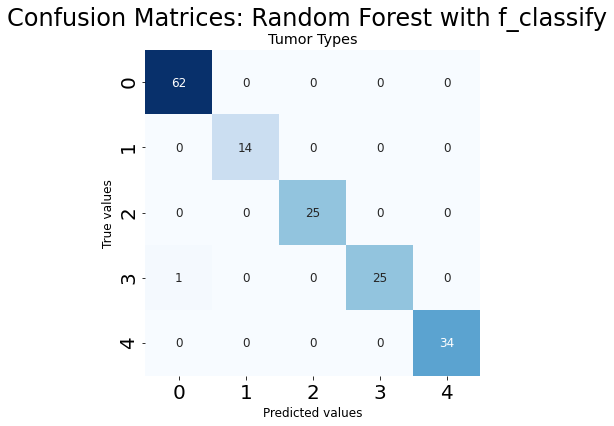

Model:Random Forest with mutual info classify,Accuracy:0.9875776397515528
Model: Random Forest with mutual info classify
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        25
           3       0.96      0.96      0.96        26
           4       1.00      0.97      0.99        34

    accuracy                           0.99       161
   macro avg       0.99      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



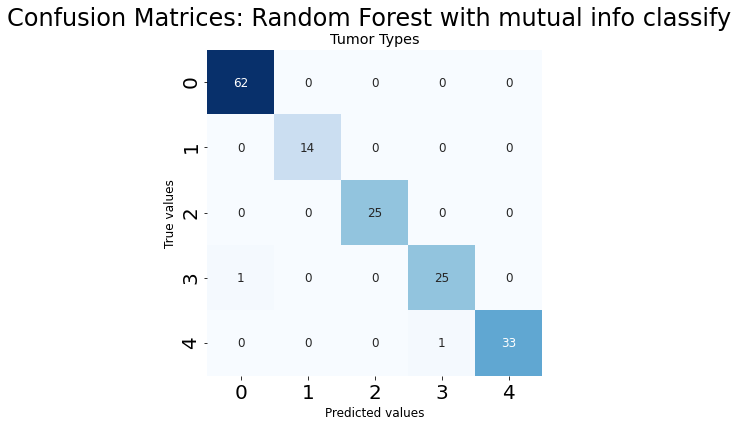

Model:Random Forest with PCA,Accuracy:0.968944099378882
Model: Random Forest with PCA
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        62
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        25
           3       0.96      0.88      0.92        26
           4       1.00      0.97      0.99        34

    accuracy                           0.97       161
   macro avg       0.98      0.97      0.97       161
weighted avg       0.97      0.97      0.97       161



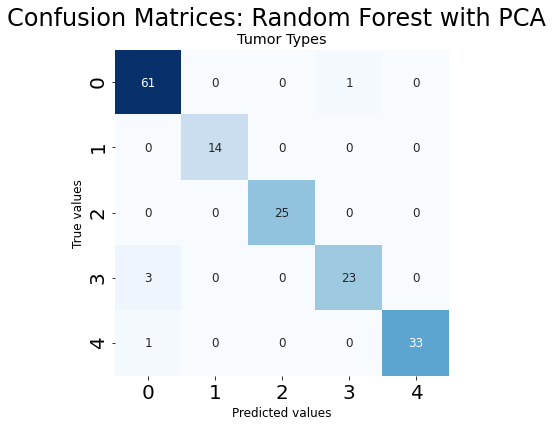

Model:Random Forest with LDA,Accuracy:0.968944099378882
Model: Random Forest with LDA
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        62
           1       0.93      1.00      0.97        14
           2       0.92      0.96      0.94        25
           3       1.00      0.96      0.98        26
           4       1.00      0.91      0.95        34

    accuracy                           0.97       161
   macro avg       0.97      0.97      0.97       161
weighted avg       0.97      0.97      0.97       161



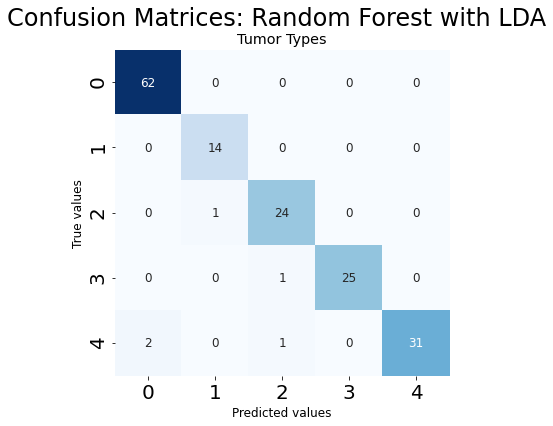

In [30]:
#random forest: performance on test set

rf=RandomForestClassifier(n_estimators=20,max_features='sqrt')

rf_pred=calc_class_metrics(rf,fclass_list[1],y_train,fclass_test_list[1],y_test,'Random Forest with f_classify')
plot_cfmat(y_test,rf_pred,'Random Forest with f_classify')

rf_pred=calc_class_metrics(rf,mutualinfo_list[1],y_train,mutualinfo_test_list[1],y_test,'Random Forest with mutual info classify')
plot_cfmat(y_test,rf_pred,'Random Forest with mutual info classify')

rf_pred=calc_class_metrics(rf,X_pc_train,y_train,X_pc_test,y_test,'Random Forest with PCA')
plot_cfmat(y_test,rf_pred,'Random Forest with PCA')

rf_pred=calc_class_metrics(rf,X_lda_train,y_train,X_lda_test,y_test,'Random Forest with LDA')
plot_cfmat(y_test,rf_pred,'Random Forest with LDA')

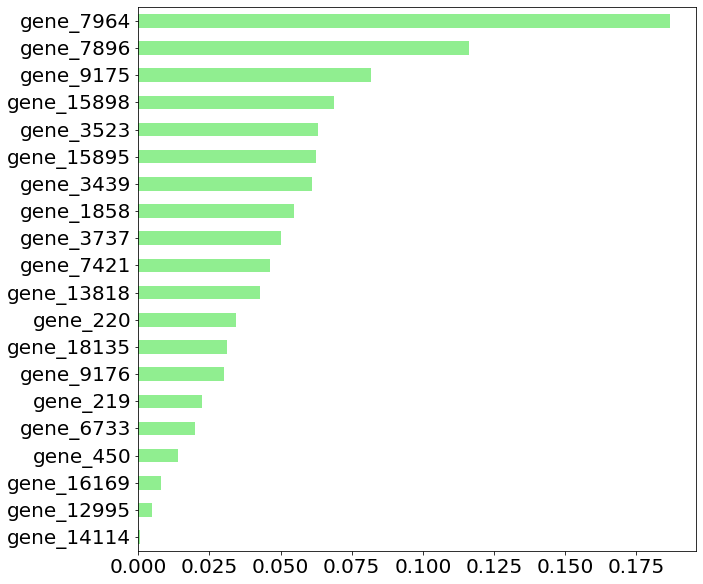

In [31]:
#random forest feature importance
rf=RandomForestClassifier(n_estimators=20,max_features='sqrt')
rf.fit(fclass_list[1],y_train)
importance_rf=pd.Series(rf.feature_importances_,index=fclass_name[1])
sorted_importance_rf=importance_rf.sort_values()

f,ax = plt.subplots()
f.set_size_inches(10,10)
sorted_importance_rf.plot(kind='barh',color='lightgreen')
plt.show()


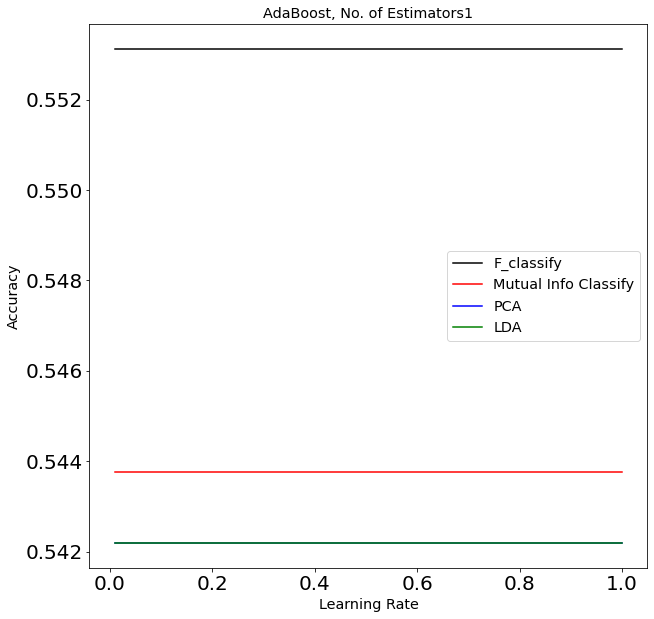

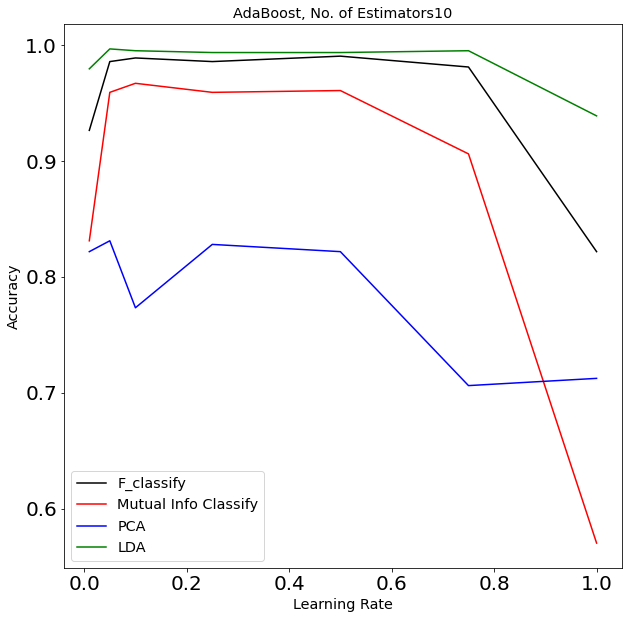

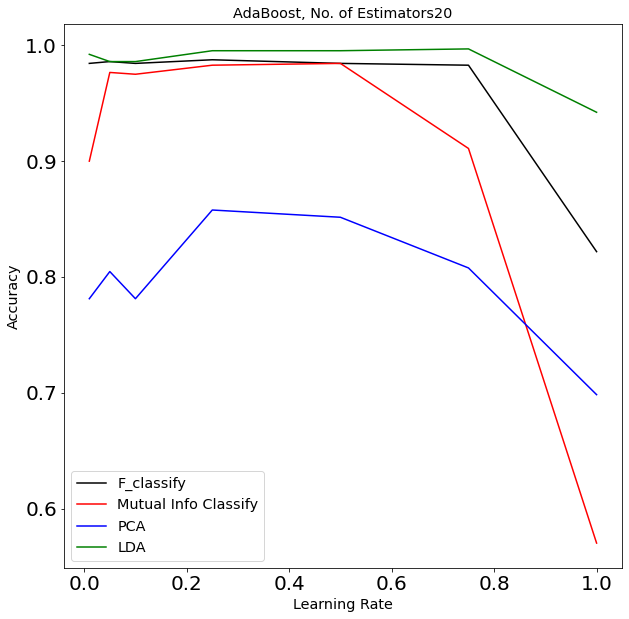

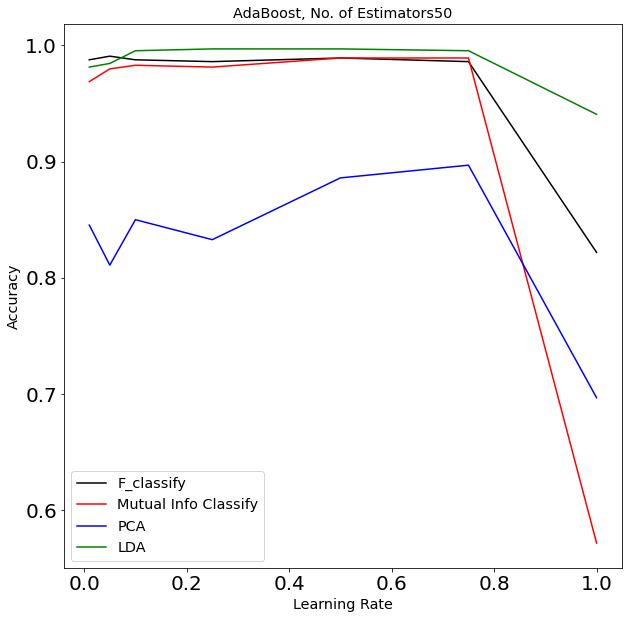

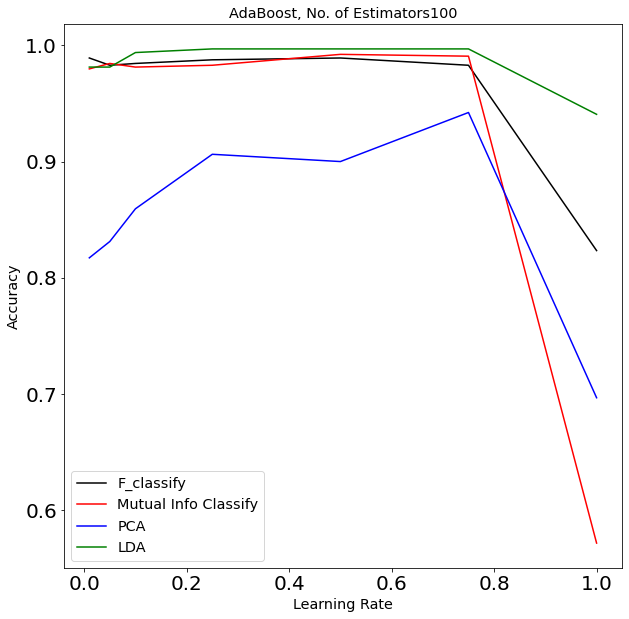

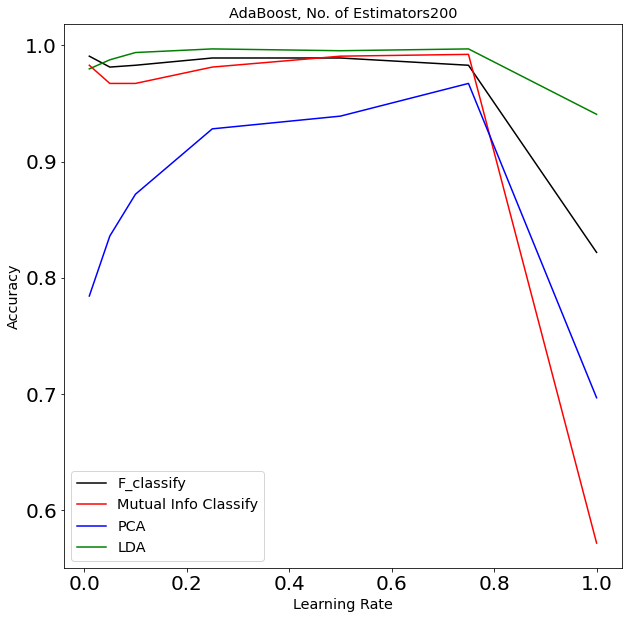

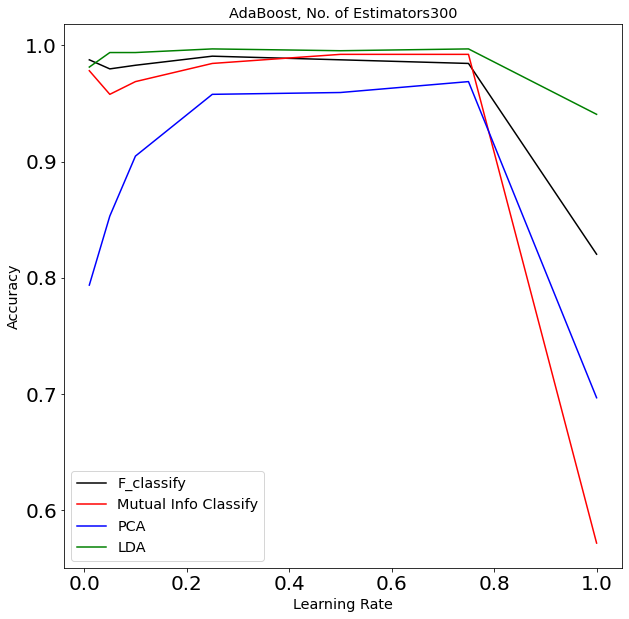

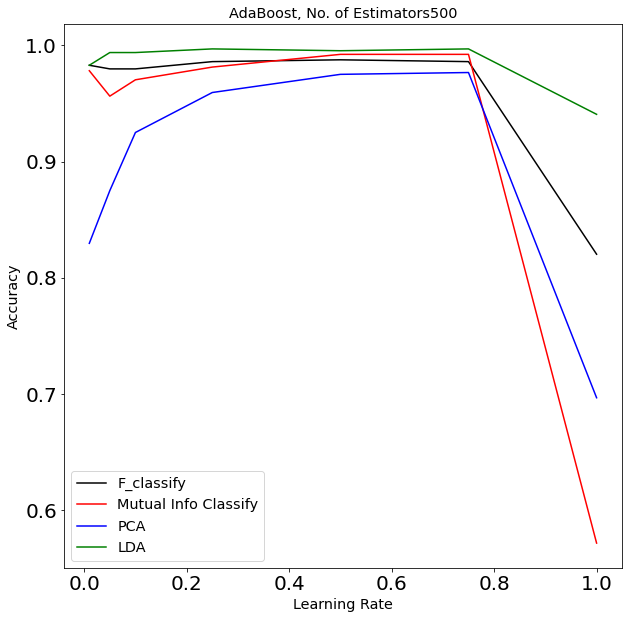

In [32]:
#AdaBoost for classification
N=[1,10,20,50,100,200,300,500]
R=[0.01,0.05,0.1,0.25,0.5,0.75,1]

for n in N:
    fclass_ada_cv_scores=[]
    mutualinfo_ada_cv_scores=[]
    pca_ada_cv_scores=[]
    lda_ada_cv_scores=[]
    for r in R:
        ada=AdaBoostClassifier(n_estimators=n,learning_rate=r)
        run_tuple=tuning(ada,fclass_list[1],mutualinfo_list[1],y_train,X_pc_train,X_lda_train)
        fclass_ada_cv_scores.append(run_tuple[0])
        mutualinfo_ada_cv_scores.append(run_tuple[1])
        pca_ada_cv_scores.append(run_tuple[2])
        lda_ada_cv_scores.append(run_tuple[3])
    plot_cv(R,fclass_ada_cv_scores,mutualinfo_ada_cv_scores,pca_ada_cv_scores,lda_ada_cv_scores,'AdaBoost, No. of Estimators'+str(n),'Learning Rate')


Model:AdaBoost with f_classify,Accuracy:0.9813664596273292
Model: AdaBoost with f_classify
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        14
           2       1.00      0.88      0.94        25
           3       0.90      1.00      0.95        26
           4       1.00      1.00      1.00        34

    accuracy                           0.98       161
   macro avg       0.98      0.98      0.98       161
weighted avg       0.98      0.98      0.98       161



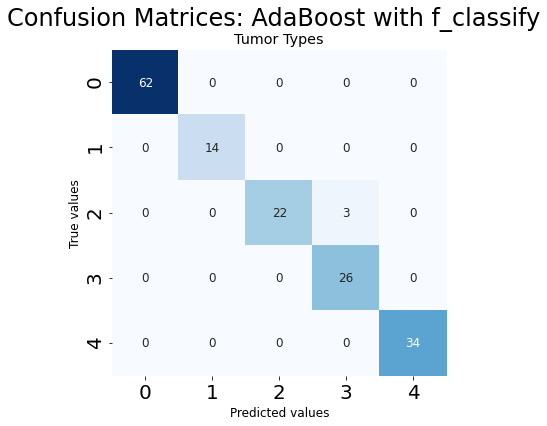

Model:AdaBoost with mutual info classify,Accuracy:0.9751552795031055
Model: AdaBoost with mutual info classify
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        25
           3       0.89      0.96      0.93        26
           4       1.00      0.91      0.95        34

    accuracy                           0.98       161
   macro avg       0.98      0.97      0.97       161
weighted avg       0.98      0.98      0.98       161



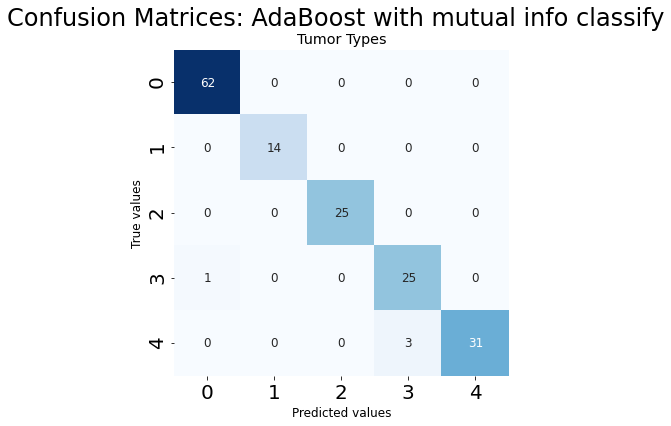

Model:AdaBoost with PCA,Accuracy:0.937888198757764
Model: AdaBoost with PCA
              precision    recall  f1-score   support

           0       0.88      0.98      0.93        62
           1       1.00      1.00      1.00        14
           2       1.00      0.92      0.96        25
           3       0.92      0.85      0.88        26
           4       1.00      0.91      0.95        34

    accuracy                           0.94       161
   macro avg       0.96      0.93      0.94       161
weighted avg       0.94      0.94      0.94       161



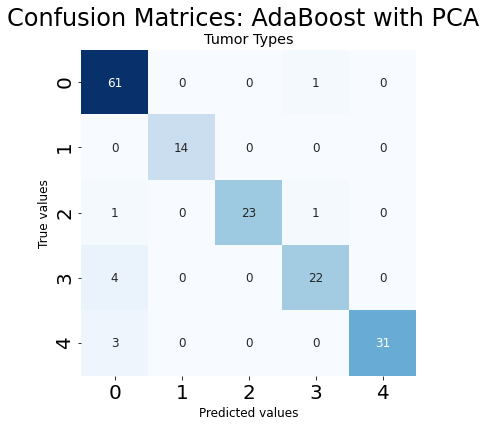

Model:AdaBoost with LDA,Accuracy:0.9751552795031055
Model: AdaBoost with LDA
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        62
           1       0.93      1.00      0.97        14
           2       1.00      0.96      0.98        25
           3       1.00      0.96      0.98        26
           4       0.97      0.94      0.96        34

    accuracy                           0.98       161
   macro avg       0.97      0.97      0.97       161
weighted avg       0.98      0.98      0.98       161



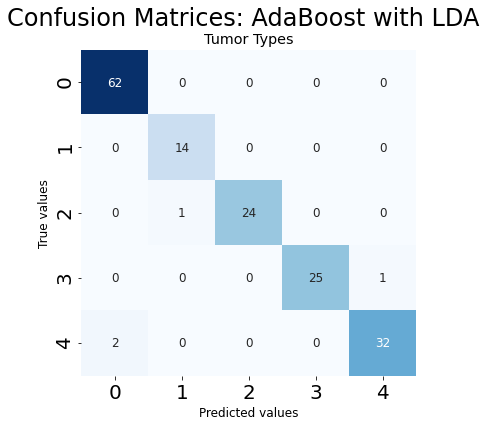

Model:AdaBoost with entire dataset,Accuracy:0.9937888198757764
Model: AdaBoost with entire dataset
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        14
           2       0.96      1.00      0.98        25
           3       1.00      0.96      0.98        26
           4       1.00      1.00      1.00        34

    accuracy                           0.99       161
   macro avg       0.99      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



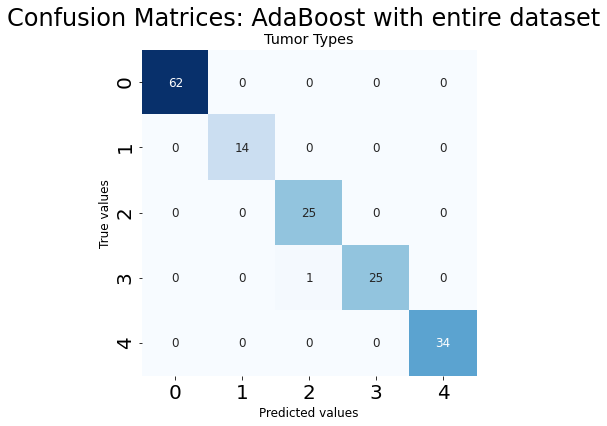

In [33]:
#Adaboost performance test set

ada=AdaBoostClassifier(n_estimators=300,learning_rate=0.5)

ada_pred=calc_class_metrics(ada,fclass_list[1],y_train,fclass_test_list[1],y_test,'AdaBoost with f_classify')
plot_cfmat(y_test,ada_pred,'AdaBoost with f_classify')

ada_pred=calc_class_metrics(ada,mutualinfo_list[1],y_train,mutualinfo_test_list[1],y_test,'AdaBoost with mutual info classify')
plot_cfmat(y_test,ada_pred,'AdaBoost with mutual info classify')

ada_pred=calc_class_metrics(ada,X_pc_train,y_train,X_pc_test,y_test,'AdaBoost with PCA')
plot_cfmat(y_test,ada_pred,'AdaBoost with PCA')

ada_pred=calc_class_metrics(ada,X_lda_train,y_train,X_lda_test,y_test,'AdaBoost with LDA')
plot_cfmat(y_test,ada_pred,'AdaBoost with LDA')

ada_pred=calc_class_metrics(ada,X_train,y_train,X_test,y_test,'AdaBoost with entire dataset')
plot_cfmat(y_test,ada_pred,'AdaBoost with entire dataset')

In [34]:
#checking multicolinearity

vifs=check_multicol(fclass_list[1],fclass_name[1],'F_classify factors: VIF')
#check_multicol(mutualinfo_list[0],mutualinfo_name[0],'Mutual Info Classify factors: VIF')


F_classify factors: VIF
      Features         VIF
0     gene_219   87.691256
1     gene_220  100.550649
2     gene_450   19.552922
3    gene_1858   12.028403
4    gene_3439   11.926143
5    gene_3523    4.192686
6    gene_3737   10.911971
7    gene_6733   13.338023
8    gene_7421   13.029104
9    gene_7896    9.996421
10   gene_7964   11.177598
11   gene_9175   34.495034
12   gene_9176   31.698183
13  gene_12995   10.834832
14  gene_13818   15.315866
15  gene_14114   18.057538
16  gene_15895   13.785051
17  gene_15898   15.276102
18  gene_16169   18.383264
19  gene_18135   14.431998


In [35]:
#logistic regression coefficient for f_classify

logreg_coef=log_coeff(fclass_list[1],y_train,fclass_name[1],'F_classify')
coef=pd.merge(logreg_coef,vifs,on='Features')
coef.to_csv('Logistic Regression Coefficients.csv')

 

Elastic Net Logistic Regression Intercept: [ 1.44178424 -1.1371281  -0.59624095  0.77339844 -0.48181363]
Elastic Net Logistic Regressionn Coefficients:F_classify:
           0         1         2         3         4    Features
0   0.000000  0.000000  0.237965 -0.033586  0.000000    gene_219
1   0.000000  0.000000  0.248644  0.000000  0.000000    gene_220
2   0.000000  0.000000  0.302492 -0.036889  0.000000    gene_450
3   0.000000  0.000000  0.691225  0.000000  0.000000   gene_1858
4  -0.123211  0.000000  0.577161  0.000000  0.000000   gene_3439
5   0.000000  2.006203 -0.015448 -0.572356  0.000000   gene_3523
6  -0.171059  0.000000  0.000000  0.000000  0.854351   gene_3737
7   0.000000  0.000000  0.653292  0.000000  0.000000   gene_6733
8   0.000000  0.000000 -0.201936  0.000000  0.000000   gene_7421
9  -1.177455  0.442834  0.000000  0.245298  0.000000   gene_7896
10 -2.004674  0.089743  0.000000  0.389608  0.000000   gene_7964
11 -0.042542  0.000000  0.000000  0.000000  0.865842   ge

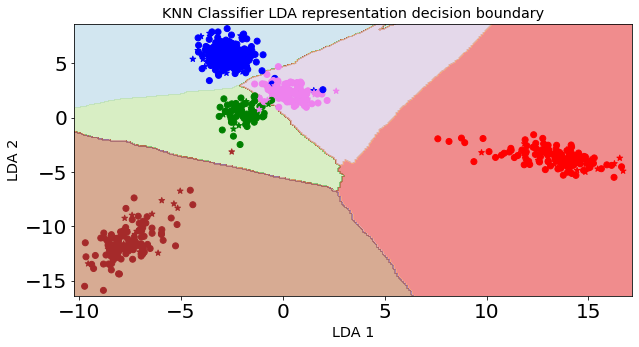

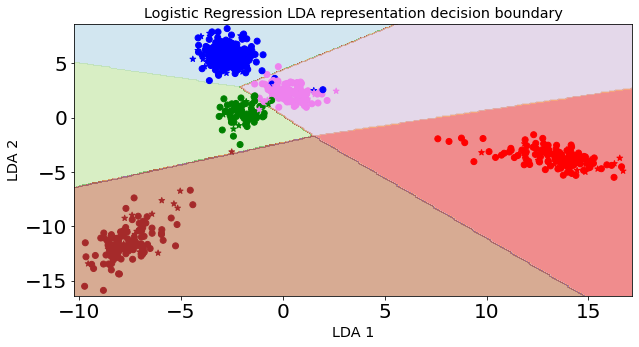

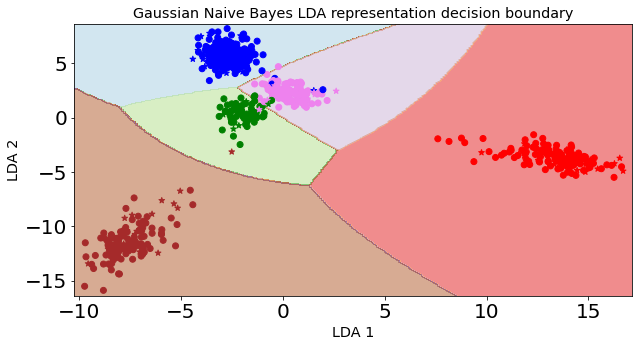

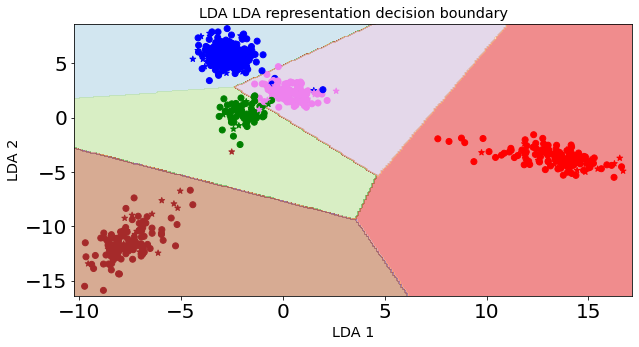

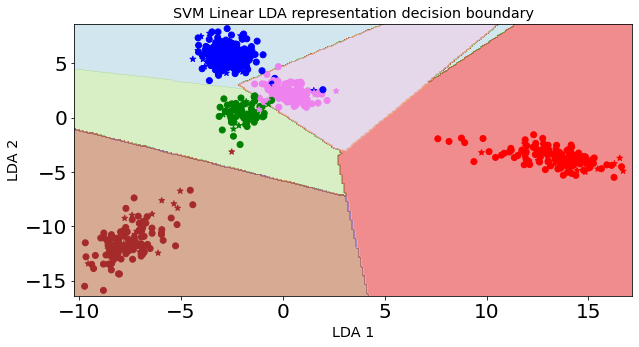

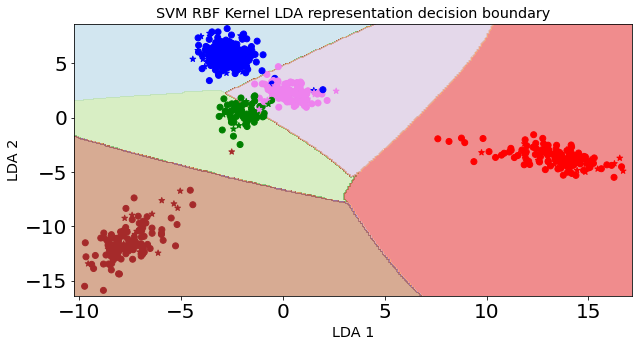

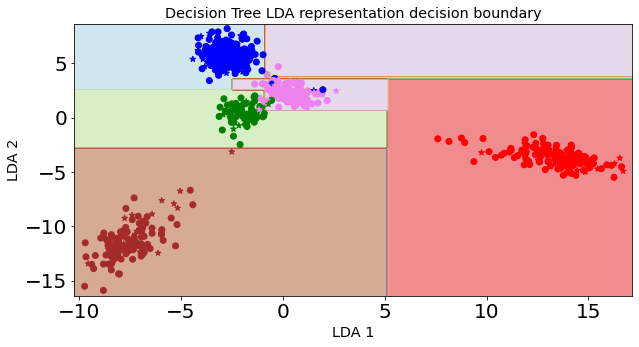

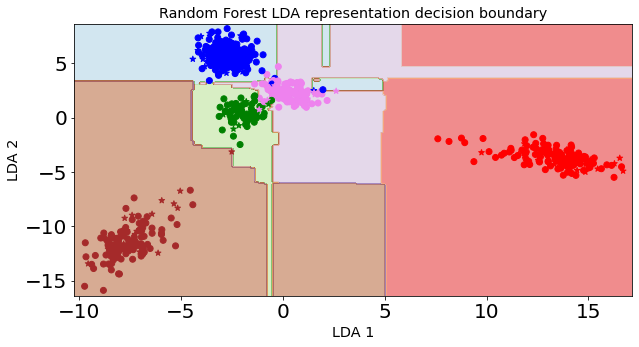

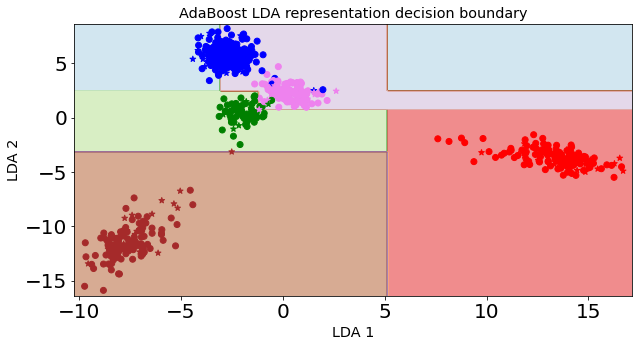

In [36]:
# LDA Decision Boundary Plots

lda_plots = LinearDiscriminantAnalysis(n_components=2)
X_lda_plots=lda_plots.fit(X, y).transform(X)

X_ldas_train, X_ldas_test, y_train, y_test = train_test_split(X_lda_plots, y, test_size=.2, random_state=0)

h=0.1
x_min, x_max = X_lda_plots[:, 0].min() - .5, X_lda_plots[:, 0].max() + .5
y_min, y_max = X_lda_plots[:, 1].min() - .5, X_lda_plots[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))



neigh1=KNeighborsClassifier(n_neighbors=5).fit(X_lda_plots,y)
logreg1=LogisticRegression(penalty='elasticnet',C=1,solver='saga',l1_ratio=0.5,multi_class='multinomial',max_iter=100000).fit(X_lda_plots,y)
gaussnb1=GaussianNB(var_smoothing=0.01).fit(X_lda_plots,y)
ldaclf1=LinearDiscriminantAnalysis().fit(X_lda_plots,y)
sv_linear1=SVC(C=0.1,kernel='linear',decision_function_shape='ovr').fit(X_lda_plots,y)
sv_kernel1=SVC(C=0.1,kernel='rbf',gamma='scale',decision_function_shape='ovr').fit(X_lda_plots,y)
dt_cart1=DecisionTreeClassifier(max_depth=6).fit(X_lda_plots,y)
rf1=RandomForestClassifier(n_estimators=20,max_features='sqrt').fit(X_lda_plots,y)
ada1=AdaBoostClassifier(n_estimators=300,learning_rate=0.5).fit(X_lda_plots,y)



plot_boundary(neigh1,'KNN Classifier',xx,yy)
plot_boundary(logreg1,'Logistic Regression',xx,yy)
plot_boundary(gaussnb1,'Gaussian Naive Bayes',xx,yy)
plot_boundary(ldaclf1,'LDA',xx,yy)
plot_boundary(sv_linear1,'SVM Linear',xx,yy)
plot_boundary(sv_kernel1,'SVM RBF Kernel',xx,yy)
plot_boundary(dt_cart1,'Decision Tree',xx,yy)
plot_boundary(rf1,'Random Forest',xx,yy)
plot_boundary(ada1,'AdaBoost',xx,yy)